In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import tensorflow as tf

# Fonction pour créer le modèle
def create_model(input_shape, units=50, dropout_rate=0.01):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Fonction principale
def main():
    # Liste des cryptomonnaies
    tickers = ['MC.PA', 'OR.PA', 'AIR.PA', 'SAN.PA', 'BNP.PA',
    'GLE.PA', 'ENGI.PA', 'VIV.PA', 'SGO.PA', 'CA.PA']  # Bitcoin, Ethereum, Binance Coin
    train_start_date = '2024-10-27'
    train_end_date = '2024-11-27'
    predict_start_date = '2024-11-28'
    predict_end_date = '2024-12-07'
    interval = '1h'

    for ticker in tickers:
        print(f"\nAnalyse pour {ticker}...\n")
        
        # Télécharger les données pour l'entraînement
        train_data = yf.download(ticker, start=train_start_date, end=train_end_date, interval=interval)
        if train_data.empty:
            print(f"Aucune donnée trouvée pour {ticker}.")
            continue
        
        # Télécharger les données pour les prédictions
        predict_data = yf.download(ticker, start=predict_start_date, end=predict_end_date, interval=interval)
        if predict_data.empty:
            print(f"Aucune donnée trouvée pour les prédictions de {ticker}.")
            continue
        
        # Utiliser uniquement les prix de clôture
        train_close = train_data['Close'].values
        predict_close = predict_data['Close'].values

        # Préparation des données pour LSTM
        time_steps = 60
        input_data = []
        labels = []
        for i in range(len(train_close) - time_steps):
            input_data.append(train_close[i:i + time_steps])
            labels.append(train_close[i + time_steps])

        # Conversion en array pour Keras
        input_data = np.array(input_data)
        labels = np.array(labels)

        # Reshape pour le modèle : [samples, time steps, features]
        input_data = np.reshape(input_data, (input_data.shape[0], input_data.shape[1], 1))

        # Séparation en données d'entraînement et de test
        train_size = int(len(input_data) * 0.8)
        x_train, x_test = input_data[:train_size], input_data[train_size:]
        y_train, y_test = labels[:train_size], labels[train_size:]

        # Création et entraînement du modèle
        model = create_model(input_shape=(time_steps, 1))
        model.fit(x_train, y_train, epochs=50, verbose=1)

        # Prédiction sur les données de test
        predictions_test = model.predict(x_test)
        rmse_test = sqrt(mean_squared_error(y_test, predictions_test))
        print(f"RMSE pour l'ensemble de test de {ticker} : {rmse_test}")

        # Prédiction sur les données futures
        prediction_input = train_close[-time_steps:]  # Dernières valeurs pour prédire
        prediction_input = np.reshape(prediction_input, (1, time_steps, 1))  # Reshape pour le modèle
        predictions_future = []

        for _ in range(len(predict_close)):  # Nombre de pas dans les données futures
            pred = model.predict(prediction_input)[0][0]
            predictions_future.append(pred)
            # Reformater pred pour correspondre à (1, 1, 1) avant de l'ajouter à prediction_input
            pred_reshaped = np.array([[[pred]]])  # Transformer le scalaire en 3D
            prediction_input = np.append(prediction_input[:, 1:, :], pred_reshaped, axis=1)

        # Appliquer une moyenne mobile pour lisser les prédictions futures
        smoothed_predictions_future = pd.Series(predictions_future).rolling(window=5).mean()

        # Visualisation des résultats
        plt.figure(figsize=(14, 8))
        
        # Obtenir les dates pour l'axe des abscisses
        train_dates = train_data.index[time_steps:]
        test_dates = train_dates[train_size:]
        predict_dates = predict_data.index
        
        # Graphique des données réelles
        plt.plot(train_data.index, train_close, label='Données réelles (Entraînement)', color='blue')
        
        # Ajouter la ligne de séparation entre entraînement et test
        plt.axvline(x=test_dates[0], color='green', linestyle='--', label='Séparation entraînement/test')
        
        # Graphique des prédictions sur l'ensemble de test
        plt.plot(test_dates, predictions_test, label='Prédictions (Test)', color='orange')

        # Graphique des prédictions futures (lissées)
        plt.plot(predict_dates, smoothed_predictions_future, label='Prédictions futures (lissées)', color='red')
        
        plt.title(f'Prédictions LSTM pour {ticker}')
        plt.xlabel('Temps')
        plt.ylabel('Prix de clôture (USD)')
        plt.legend()
        plt.grid()
        plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed


Analyse pour MC...




[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OR.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Aucune donnée trouvée pour les prédictions de MC.

Analyse pour OR.PA...

Aucune donnée trouvée pour les prédictions de OR.PA.

Analyse pour AIR.PA...





1 Failed download:
['AIR.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SAN.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed


Aucune donnée trouvée pour les prédictions de AIR.PA.

Analyse pour SAN.PA...

Aucune donnée trouvée pour les prédictions de SAN.PA.

Analyse pour BNP.PA...



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BNP.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLE.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Aucune donnée trouvée pour les prédictions de BNP.PA.

Analyse pour GLE.PA...

Aucune donnée trouvée pour les prédictions de GLE.PA.

Analyse pour ENGI.PA...





1 Failed download:
['ENGI.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VIV.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed


Aucune donnée trouvée pour les prédictions de ENGI.PA.

Analyse pour VIV.PA...

Aucune donnée trouvée pour les prédictions de VIV.PA.

Analyse pour SGO.PA...



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SGO.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CA.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-11-28 -> 2024-12-07)')


Aucune donnée trouvée pour les prédictions de SGO.PA.

Analyse pour CA.PA...

Aucune donnée trouvée pour les prédictions de CA.PA.


[*********************100%***********************]  1 of 1 completed


Analyse pour MC.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 482.4510
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 455.2652
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 457.1516
Epoch 4/50
1/1 [==============================] - 0s 10ms/step - loss: 432.2174
Epoch 5/50
1/1 [==============================] - 0s 10ms/step - loss: 432.8828
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 417.2868
Epoch 7/50
1/1 [==============================] - 0s 9ms/step - loss: 403.6815
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 392.3892
Epoch 9/50
1/1 [==============================] - 0s 14ms/step - loss: 384.9443
Epoch 10/50
1/1 [==============================] - 0s 10ms/step - loss: 372.7743
Epoch 11/50
1/1 [==============================] - 0s 10ms/step - loss: 364.6777
Epoch 12/50
1/1 [==============================] - 0s 10ms/step - loss: 355.2875
Epoch 13/50
1/1 [===========================

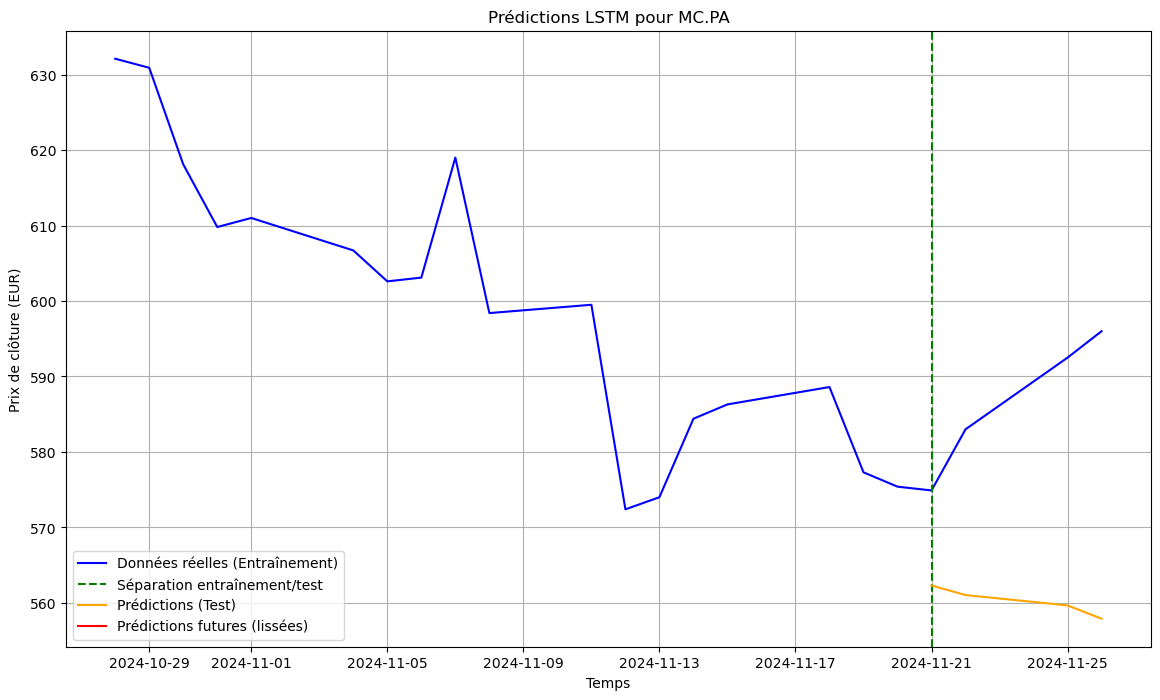

[*********************100%***********************]  1 of 1 completed


Analyse pour OR.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 349.7356
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 345.9986
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 342.8449
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 339.2280
Epoch 5/50
1/1 [==============================] - 0s 9ms/step - loss: 335.2790
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 334.2513
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 333.5865
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 333.3043
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 332.4665
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 331.8432
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 331.0828
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 330.1253
Epoch 13/50
1/1 [==============================] -

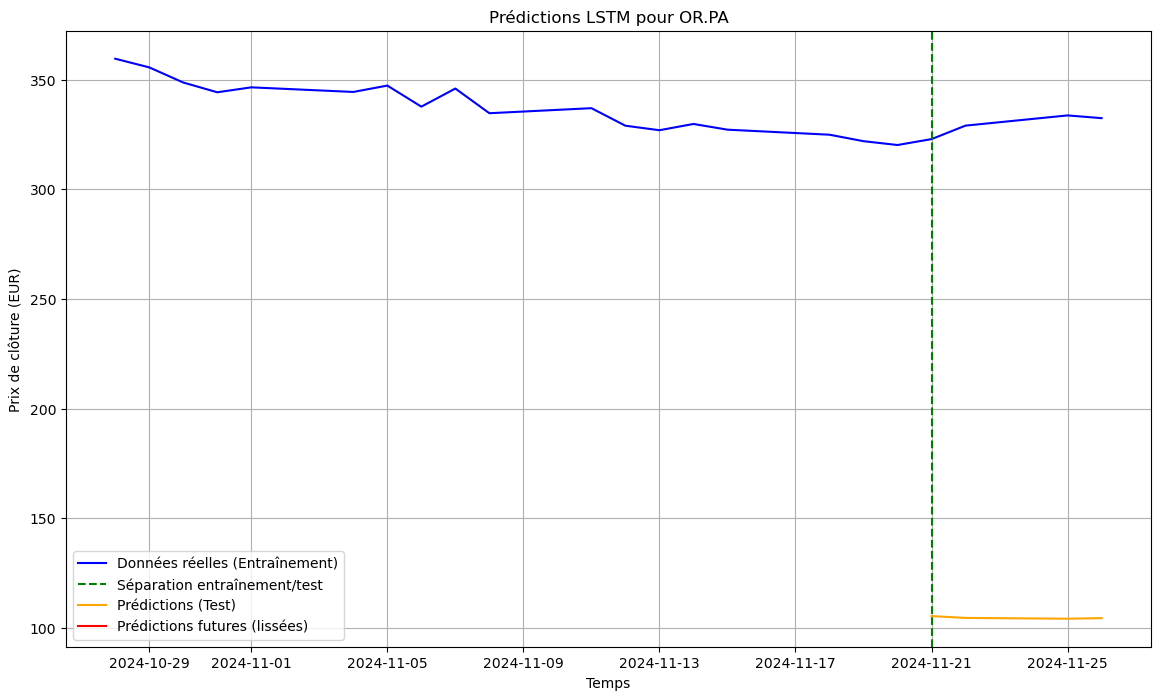

[*********************100%***********************]  1 of 1 completed


Analyse pour AIR.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 150.5680
Epoch 2/50
1/1 [==============================] - 0s 10ms/step - loss: 147.1176
Epoch 3/50
1/1 [==============================] - 0s 16ms/step - loss: 142.8116
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 138.4196
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 132.2503
Epoch 6/50
1/1 [==============================] - 0s 9ms/step - loss: 128.1039
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 123.9920
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 107.8606
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 83.9897
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 78.8189
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 74.2729
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 68.7747
Epoch 13/50
1/1 [==============================] - 0

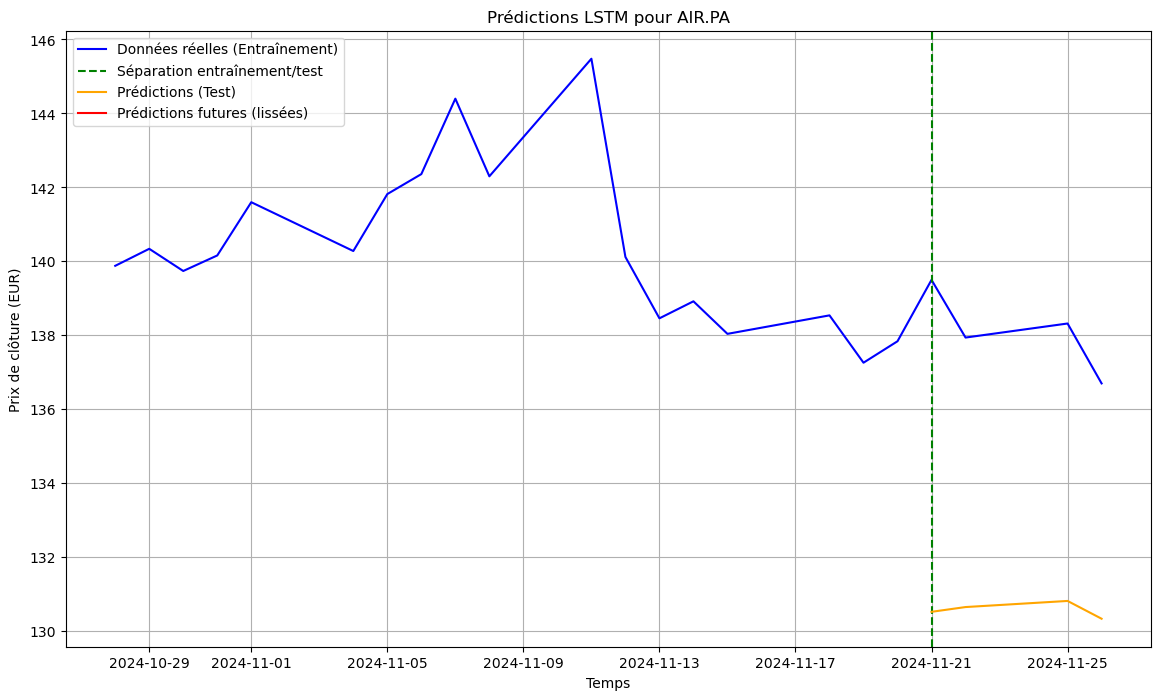

[*********************100%***********************]  1 of 1 completed


Analyse pour SAN.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 103.4334
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 100.2746
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 99.4464
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 97.7966
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 96.0026
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 94.1864
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 92.3940
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 90.6264
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 88.9700
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 86.4612
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 83.9825
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 77.6210
Epoch 13/50
1/1 [==============================] - 0s 6ms/st

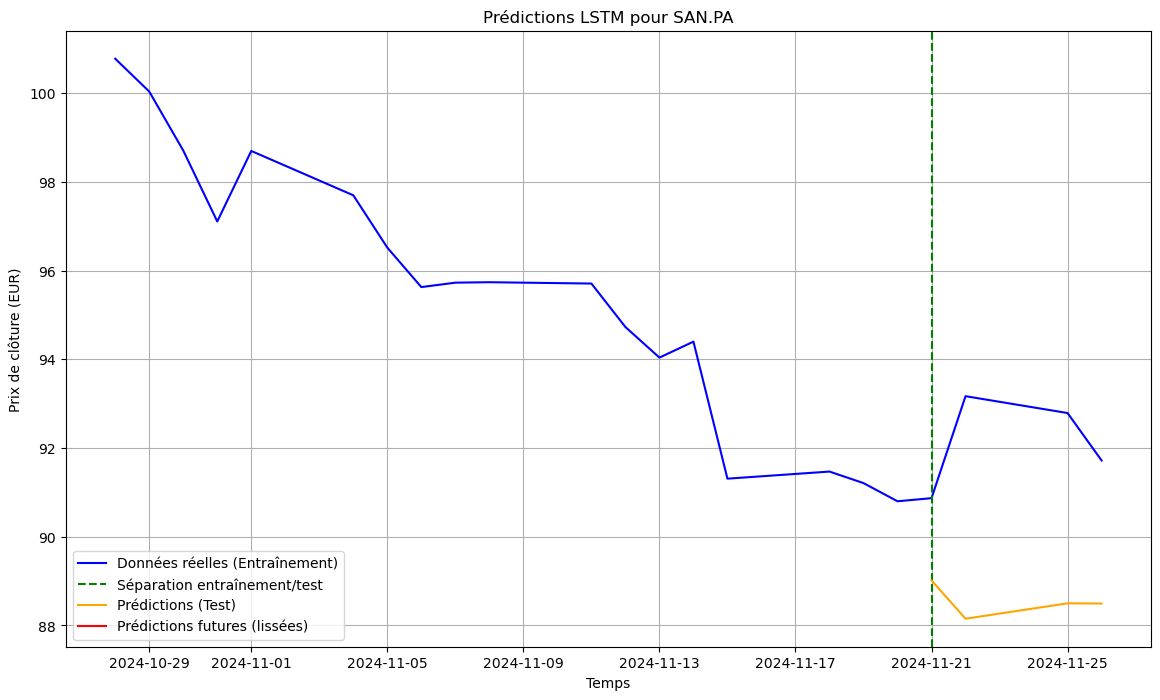

[*********************100%***********************]  1 of 1 completed


Analyse pour BNP.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 43.6602
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 38.6410
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 34.3425
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 28.9683
Epoch 5/50
1/1 [==============================] - 0s 6ms/step - loss: 21.0981
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 5.7463
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 17.1054
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 3.0371
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 7.9151
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 1.5527
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 5.4296
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 1.5782
Epoch 13/50
1/1 [==============================] - 0s 6ms/step - los

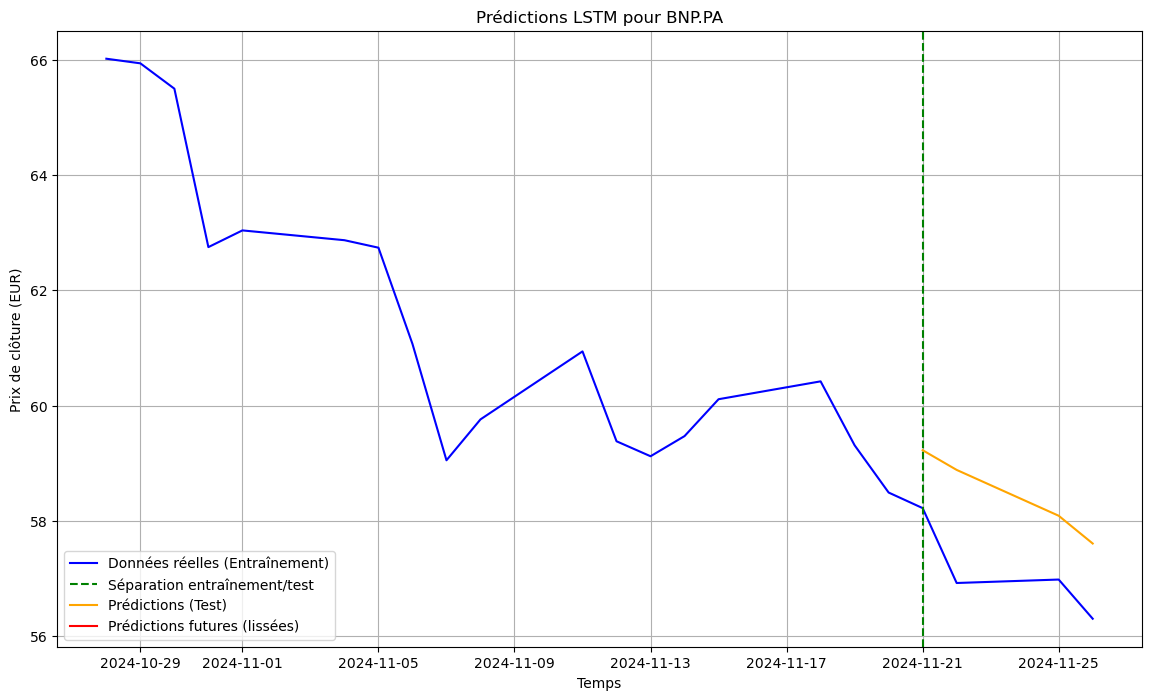

[*********************100%***********************]  1 of 1 completed


Analyse pour GLE.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 21.5687
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 19.8322
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 18.6670
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 17.4443
Epoch 5/50
1/1 [==============================] - 0s 6ms/step - loss: 16.0350
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 13.7913
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 11.1057
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 8.1248
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 4.0008
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 1.9532
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 3.0737
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 2.1395
Epoch 13/50
1/1 [==============================] - 0s 6ms/step - lo

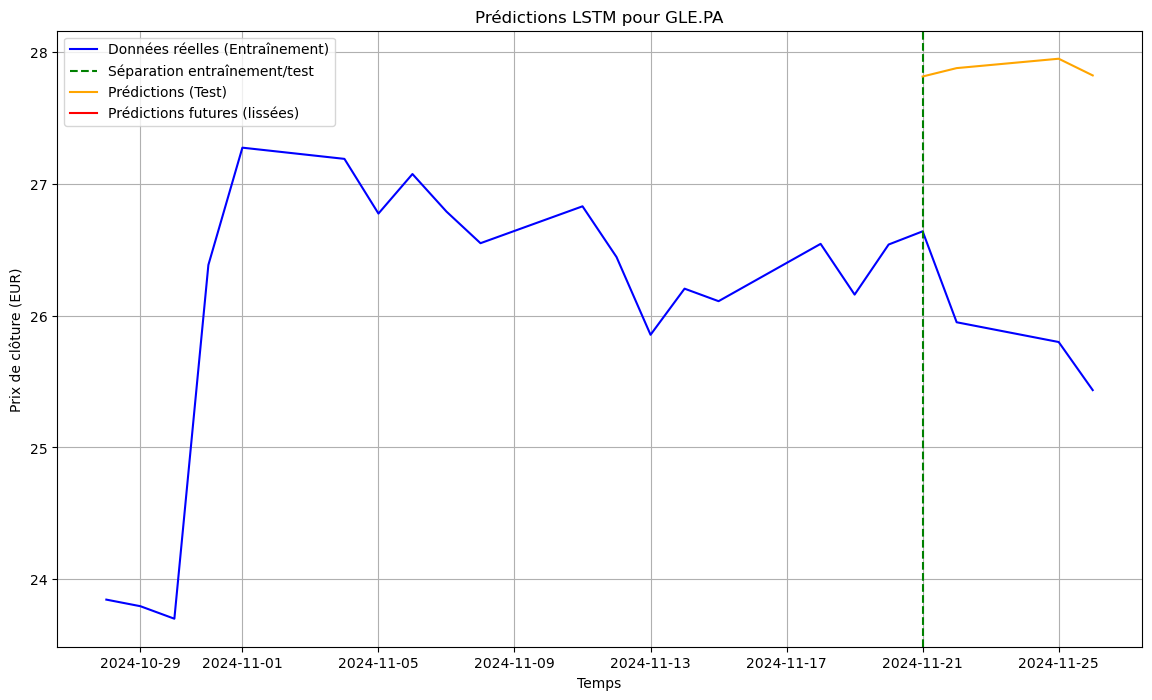

[*********************100%***********************]  1 of 1 completed


Analyse pour ENGI.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 15.1742
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 14.6680
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 14.2302
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 13.8758
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 13.4700
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 13.0503
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 12.5467
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 11.9993
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 11.3202
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 10.6049
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 9.5185
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 8.2070
Epoch 13/50
1/1 [==============================] - 0s 7ms/step -

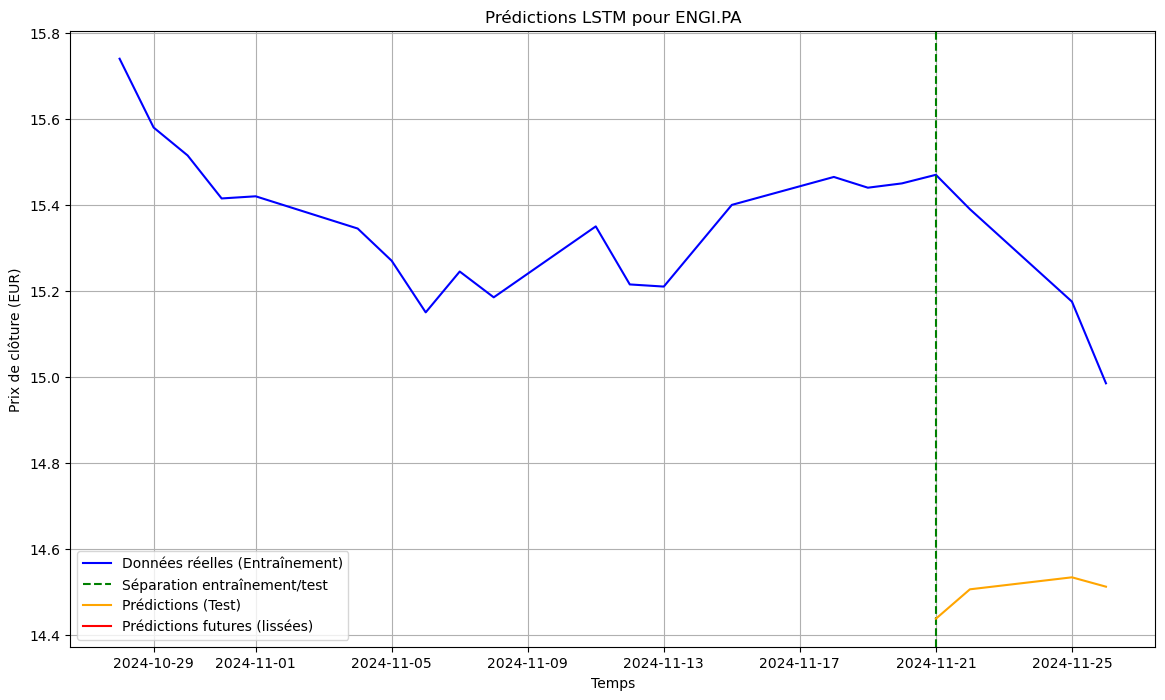

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour VIV.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 8.8316
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 8.0840
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 7.4779
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 6.9192
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 6.2837
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 5.6181
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 4.9330
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 4.0688
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 2.8363
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 1.3647
Epoch 11/50
1/1 [==============================] - 0s 5ms/step - loss: 0.5180
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 1.3298
Epoch 13/50
1/1 [==============================] - 0s 6ms/step - loss: 0.3

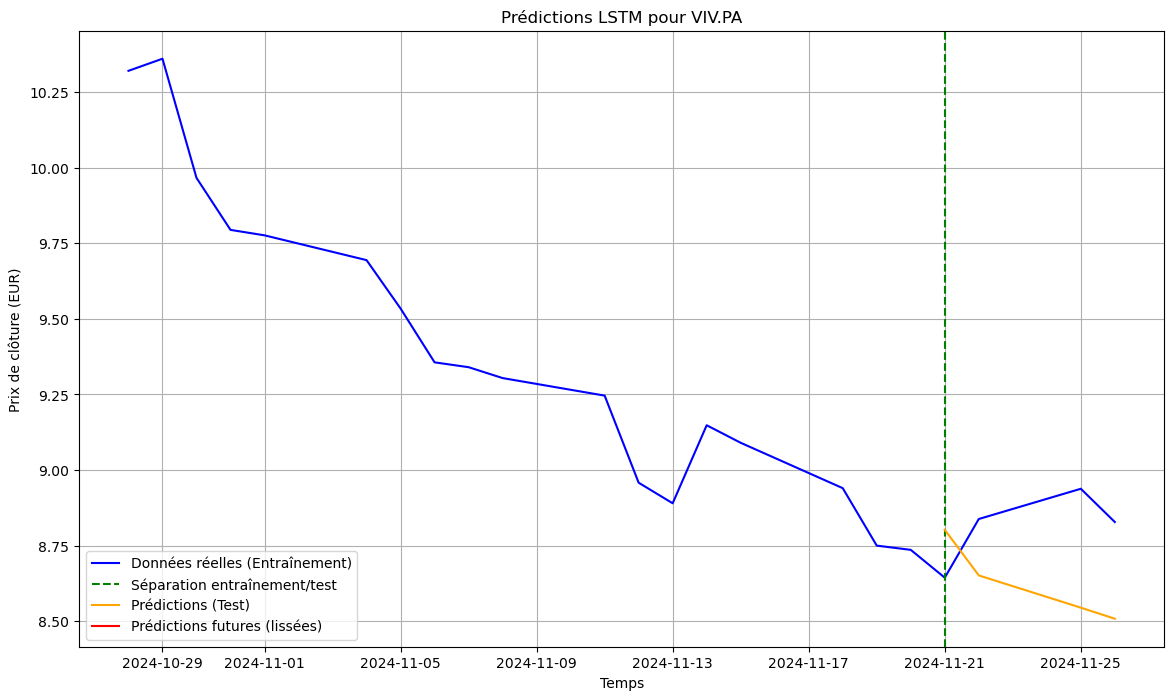

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour SGO.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 91.3779
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 90.6972
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 90.4004
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 90.1433
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 89.9148
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 89.6954
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 89.4449
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 89.1357
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 89.0058
Epoch 10/50
1/1 [==============================] - 0s 9ms/step - loss: 88.6570
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 88.4869
Epoch 12/50
1/1 [==============================] - 0s 8ms/step - loss: 88.0500
Epoch 13/50
1/1 [==============================] - 0s 9ms/step

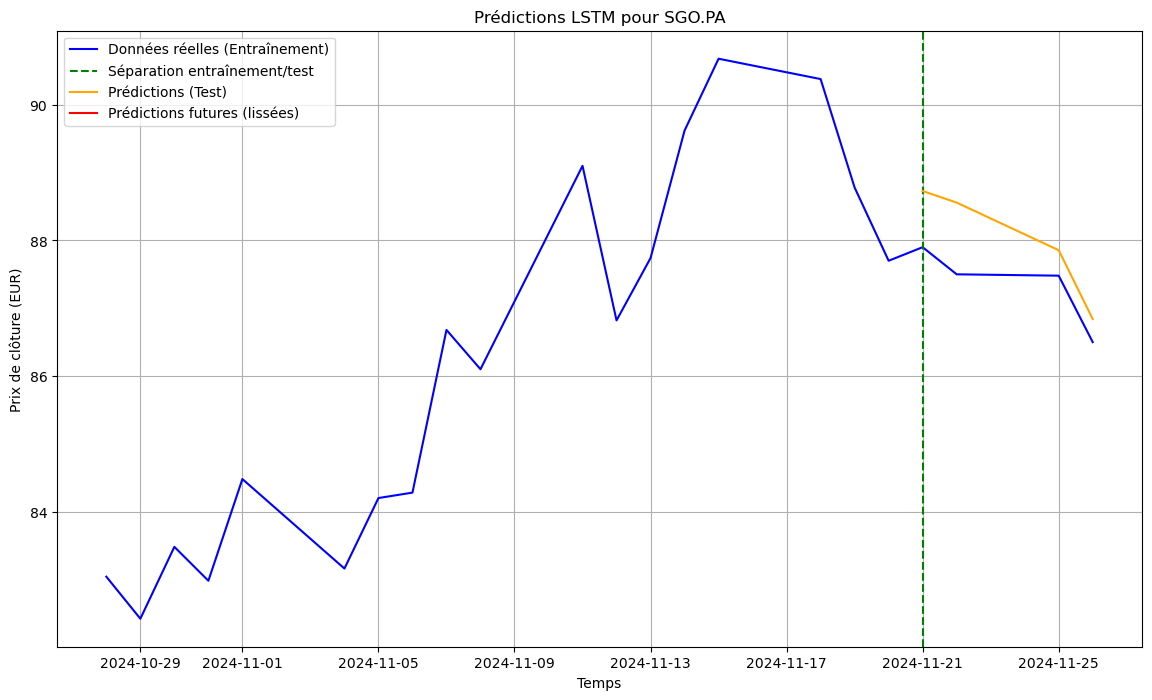

[*********************100%***********************]  1 of 1 completed


Analyse pour CA.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 14.5307
Epoch 2/50
1/1 [==============================] - 0s 10ms/step - loss: 14.0192
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 13.7130
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 13.4131
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 13.1120
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 12.8858
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 12.5946
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 12.4942
Epoch 9/50
1/1 [==============================] - 0s 9ms/step - loss: 12.0326
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 11.7354
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 11.5204
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 10.9807
Epoch 13/50
1/1 [==============================] - 0s 7ms/ste

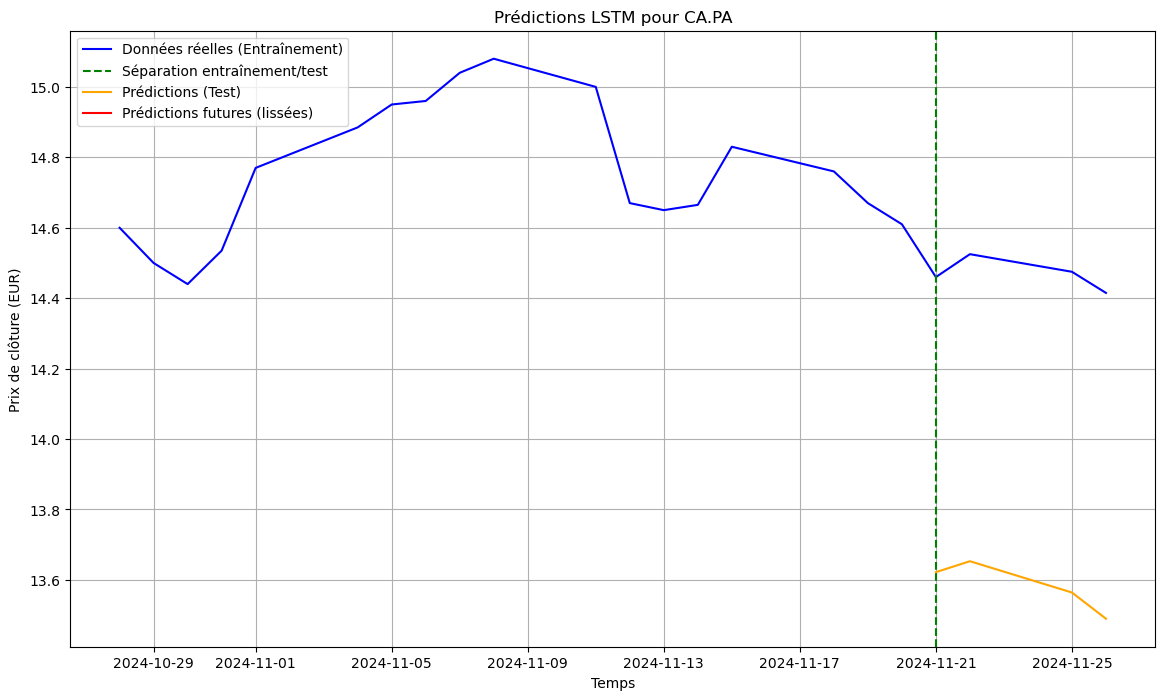

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import tensorflow as tf

# Fonction pour créer le modèle
def create_model(input_shape, units=50, dropout_rate=0.01):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Fonction principale
def main():
    # Liste des tickers pour les actions du CAC 40
    tickers = ['MC.PA', 'OR.PA', 'AIR.PA', 'SAN.PA', 'BNP.PA',
               'GLE.PA', 'ENGI.PA', 'VIV.PA', 'SGO.PA', 'CA.PA']  # LVMH, L'Oréal, Airbus, Sanofi, etc.
    train_start_date = '2024-10-27'
    train_end_date = '2024-11-27'
    predict_start_date = '2024-11-28'
    predict_end_date = '2024-12-07'
    interval = '1d'  # Intervalle modifié à "1d" pour les actions

    for ticker in tickers:
        print(f"\nAnalyse pour {ticker}...\n")
        
        # Télécharger les données pour l'entraînement
        train_data = yf.download(ticker, start=train_start_date, end=train_end_date, interval=interval)
        if train_data.empty:
            print(f"Aucune donnée trouvée pour {ticker}.")
            continue
        
        # Télécharger les données pour les prédictions
        predict_data = yf.download(ticker, start=predict_start_date, end=predict_end_date, interval=interval)
        if predict_data.empty:
            print(f"Aucune donnée trouvée pour les prédictions de {ticker}.")
            continue
        
        # Utiliser uniquement les prix de clôture
        train_close = train_data['Close'].values
        predict_close = predict_data['Close'].values

        # Préparation des données pour LSTM
        time_steps = 5  # Réduction du nombre de pas pour s'adapter aux données journalières
        input_data = []
        labels = []
        for i in range(len(train_close) - time_steps):
            input_data.append(train_close[i:i + time_steps])
            labels.append(train_close[i + time_steps])

        # Conversion en array pour Keras
        input_data = np.array(input_data)
        labels = np.array(labels)

        # Reshape pour le modèle : [samples, time steps, features]
        input_data = np.reshape(input_data, (input_data.shape[0], input_data.shape[1], 1))

        # Séparation en données d'entraînement et de test
        train_size = int(len(input_data) * 0.8)
        x_train, x_test = input_data[:train_size], input_data[train_size:]
        y_train, y_test = labels[:train_size], labels[train_size:]

        # Création et entraînement du modèle
        model = create_model(input_shape=(time_steps, 1))
        model.fit(x_train, y_train, epochs=50, verbose=1)

        # Prédiction sur les données de test
        predictions_test = model.predict(x_test)
        rmse_test = sqrt(mean_squared_error(y_test, predictions_test))
        print(f"RMSE pour l'ensemble de test de {ticker} : {rmse_test}")

        # Prédiction sur les données futures
        prediction_input = train_close[-time_steps:]  # Dernières valeurs pour prédire
        prediction_input = np.reshape(prediction_input, (1, time_steps, 1))  # Reshape pour le modèle
        predictions_future = []

        for _ in range(len(predict_close)):  # Nombre de pas dans les données futures
            pred = model.predict(prediction_input)[0][0]
            predictions_future.append(pred)
            # Reformater pred pour correspondre à (1, 1, 1) avant de l'ajouter à prediction_input
            pred_reshaped = np.array([[[pred]]])  # Transformer le scalaire en 3D
            prediction_input = np.append(prediction_input[:, 1:, :], pred_reshaped, axis=1)

        # Appliquer une moyenne mobile pour lisser les prédictions futures
        smoothed_predictions_future = pd.Series(predictions_future).rolling(window=3).mean()

        # Visualisation des résultats
        plt.figure(figsize=(14, 8))
        
        # Obtenir les dates pour l'axe des abscisses
        train_dates = train_data.index[time_steps:]
        test_dates = train_dates[train_size:]
        predict_dates = predict_data.index
        
        # Graphique des données réelles
        plt.plot(train_data.index, train_close, label='Données réelles (Entraînement)', color='blue')
        
        # Ajouter la ligne de séparation entre entraînement et test
        plt.axvline(x=test_dates[0], color='green', linestyle='--', label='Séparation entraînement/test')
        
        # Graphique des prédictions sur l'ensemble de test
        plt.plot(test_dates, predictions_test, label='Prédictions (Test)', color='orange')

        # Graphique des prédictions futures (lissées)
        plt.plot(predict_dates, smoothed_predictions_future, label='Prédictions futures (lissées)', color='red')
        
        plt.title(f'Prédictions LSTM pour {ticker}')
        plt.xlabel('Temps')
        plt.ylabel('Prix de clôture (EUR)')
        plt.legend()
        plt.grid()
        plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour MC.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 637.3356
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 631.8373
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 628.7258
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 628.6137
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 624.6405
Epoch 6/50
1/1 [==============================] - 0s 10ms/step - loss: 627.2543
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 626.3264
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 625.2579
Epoch 9/50
1/1 [==============================] - 0s 10ms/step - loss: 623.2394
Epoch 10/50
1/1 [==============================] - 0s 9ms/step - loss: 620.3538
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 623.0979
Epoch 12/50
1/1 [==============================] - 0s 9ms/step - loss: 621.9162
Epoch 13/50
1/1 [==============================]

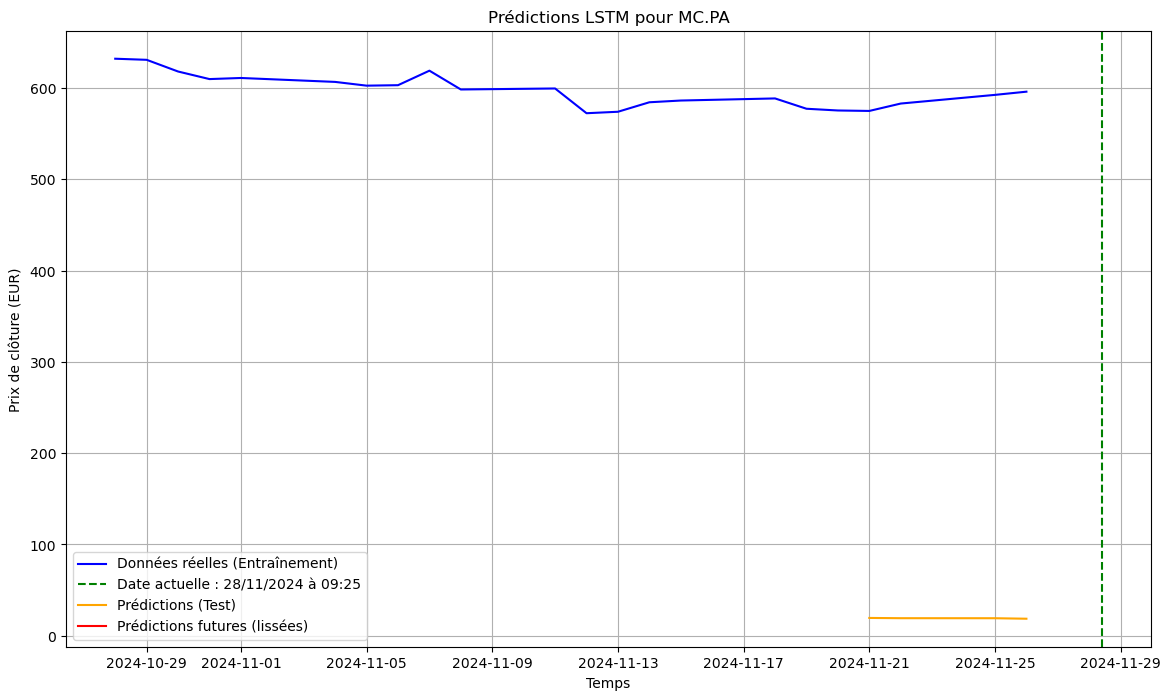

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour OR.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 391.7102
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 373.9155
Epoch 3/50
1/1 [==============================] - 0s 10ms/step - loss: 364.3921
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 356.5728
Epoch 5/50
1/1 [==============================] - 0s 9ms/step - loss: 349.2444
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 346.1259
Epoch 7/50
1/1 [==============================] - 0s 9ms/step - loss: 336.7559
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 325.5578
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 318.4647
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 306.8398
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 301.7899
Epoch 12/50
1/1 [==============================] - 0s 8ms/step - loss: 297.8014
Epoch 13/50
1/1 [==============================] 

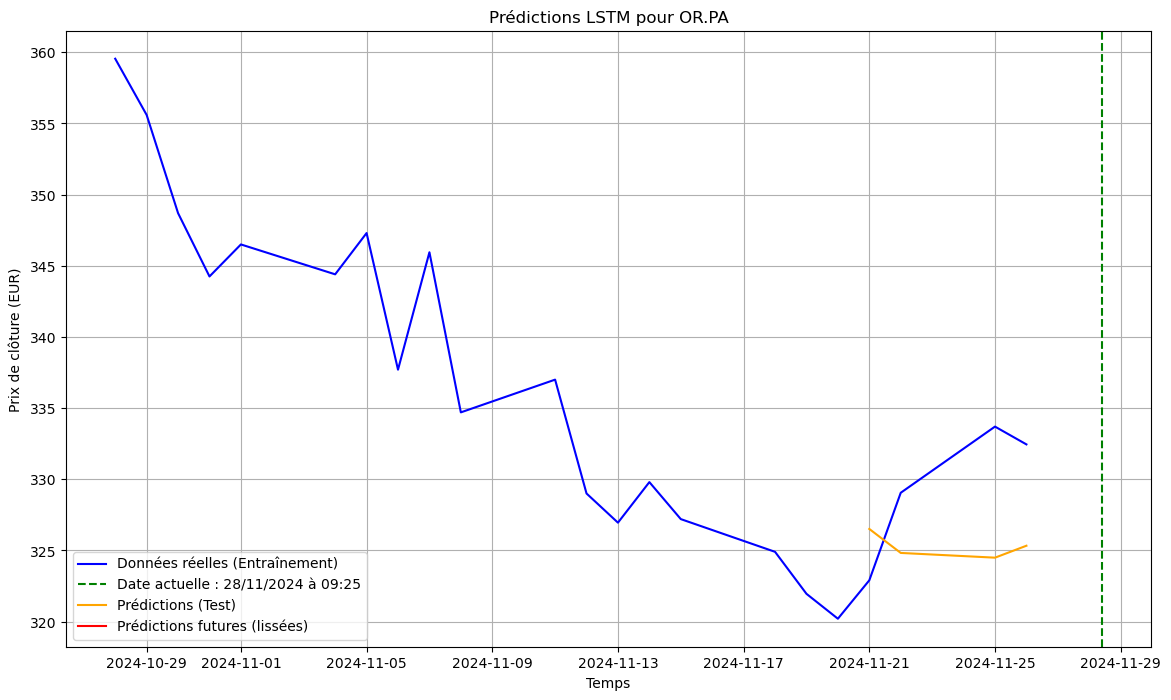

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour AIR.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 110.5832
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 103.8345
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 96.7829
Epoch 4/50
1/1 [==============================] - 0s 10ms/step - loss: 91.1231
Epoch 5/50
1/1 [==============================] - 0s 10ms/step - loss: 89.1128
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 82.7070
Epoch 7/50
1/1 [==============================] - 0s 9ms/step - loss: 77.4662
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 64.4498
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 38.5088
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 29.9689
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 23.1833
Epoch 12/50
1/1 [==============================] - 0s 8ms/step - loss: 15.6522
Epoch 13/50
1/1 [==============================] - 0s 10ms

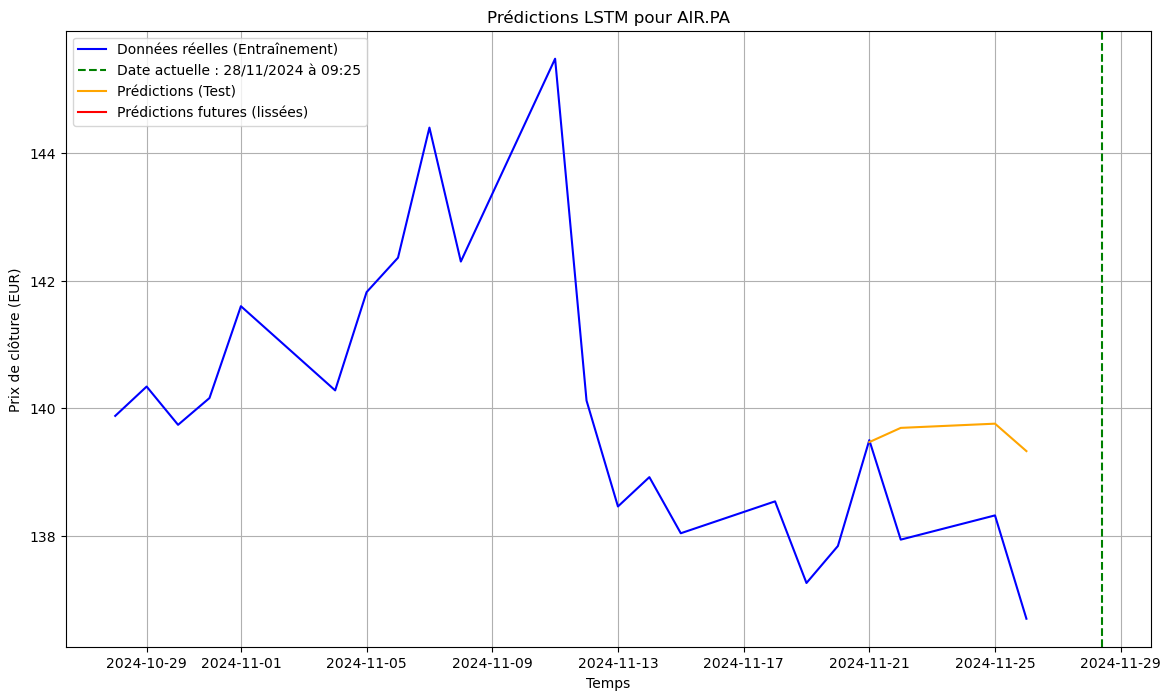

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour SAN.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 101.0256
Epoch 2/50
1/1 [==============================] - 0s 10ms/step - loss: 97.9907
Epoch 3/50
1/1 [==============================] - 0s 12ms/step - loss: 95.5464
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 92.2492
Epoch 5/50
1/1 [==============================] - 0s 9ms/step - loss: 89.3108
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 86.1767
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 81.8908
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 76.2872
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 71.1483
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 65.2722
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 59.2234
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 53.5508
Epoch 13/50
1/1 [==============================] - 0s 7ms/s

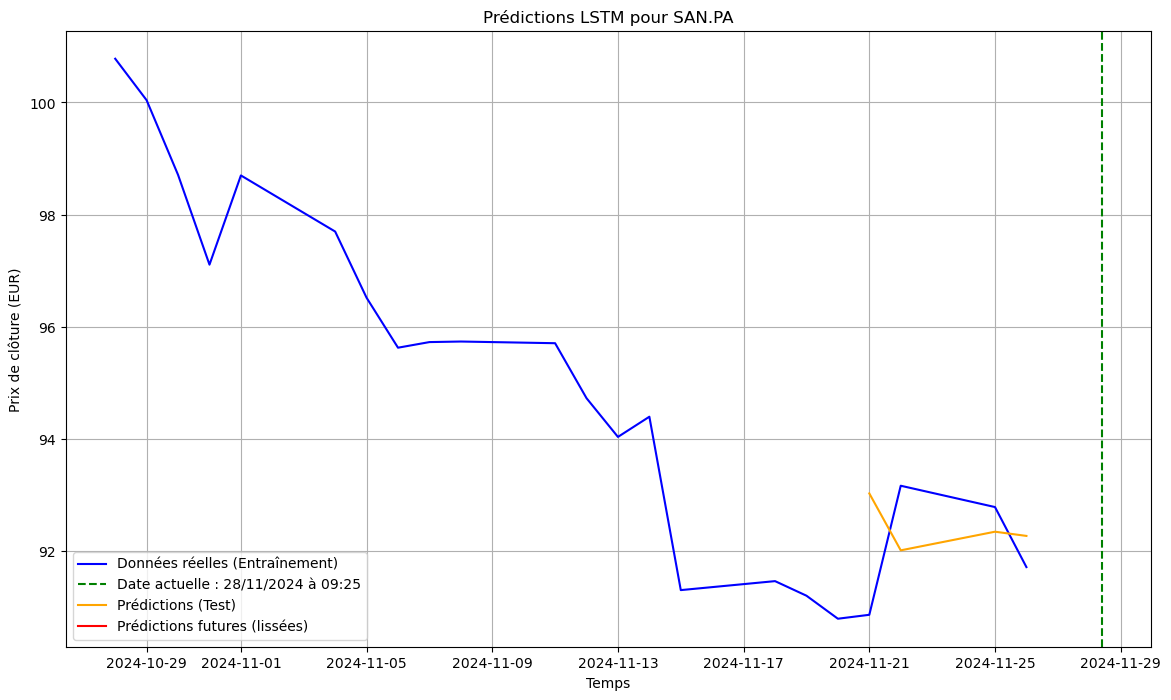

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour BNP.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 60.2086
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 49.3676
Epoch 3/50
1/1 [==============================] - 0s 11ms/step - loss: 38.6625
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 28.9719
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 17.7165
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 5.5882
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 12.8726
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 3.6337
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 6.9903
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 1.8154
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 3.9934
Epoch 12/50
1/1 [==============================] - 0s 9ms/step - loss: 3.9790
Epoch 13/50
1/1 [==============================] - 0s 8ms/step - lo

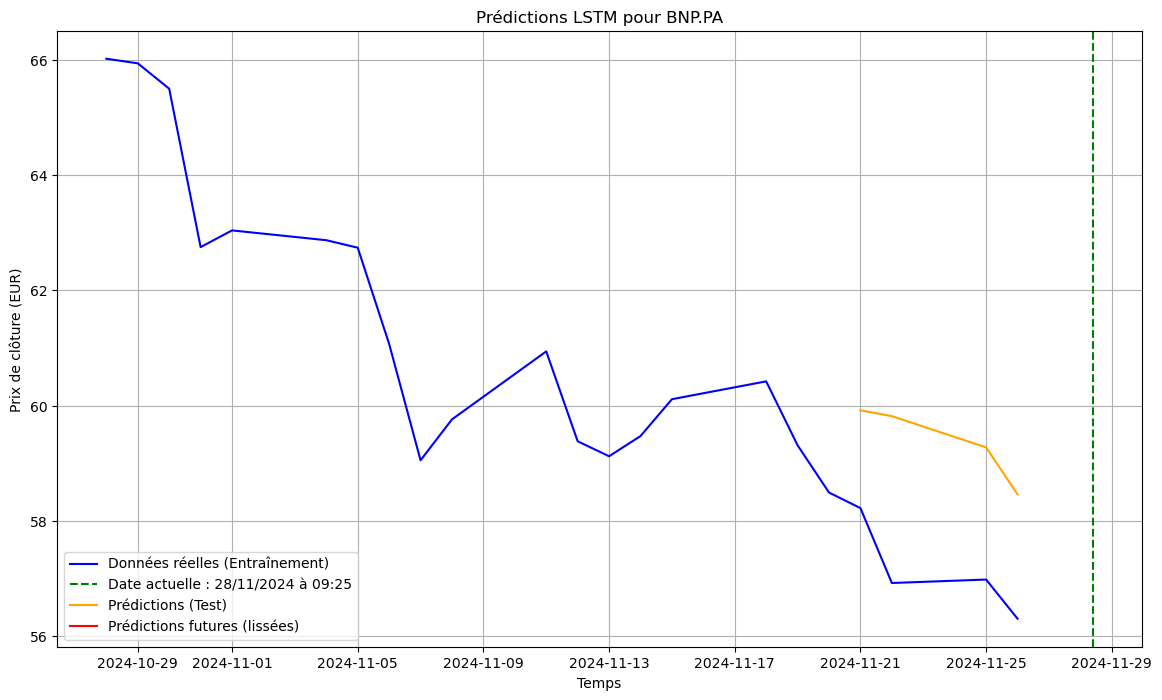

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour GLE.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 22.2273
Epoch 2/50
1/1 [==============================] - 0s 10ms/step - loss: 20.6192
Epoch 3/50
1/1 [==============================] - 0s 12ms/step - loss: 18.9418
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 17.1687
Epoch 5/50
1/1 [==============================] - 0s 10ms/step - loss: 14.8974
Epoch 6/50
1/1 [==============================] - 0s 9ms/step - loss: 12.6301
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 8.2489
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 3.3301
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 3.2336
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 2.9146
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 1.6310
Epoch 12/50
1/1 [==============================] - 0s 8ms/step - loss: 2.0262
Epoch 13/50
1/1 [==============================] - 0s 7ms/step - 

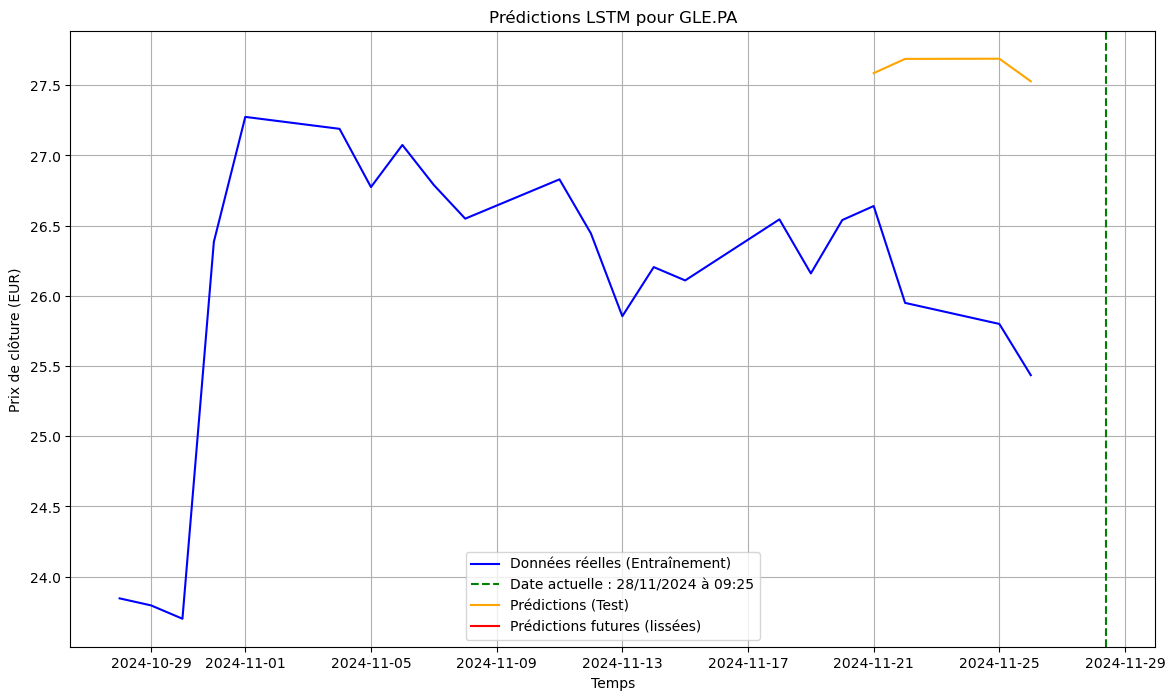

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour ENGI.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 14.4032
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 13.9964
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 13.6048
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 13.3274
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 12.9478
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 12.6419
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 12.2427
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 11.8198
Epoch 9/50
1/1 [==============================] - 0s 11ms/step - loss: 11.3285
Epoch 10/50
1/1 [==============================] - 0s 11ms/step - loss: 10.8322
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 10.0507
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 9.3184
Epoch 13/50
1/1 [==============================] - 0s 10ms/st

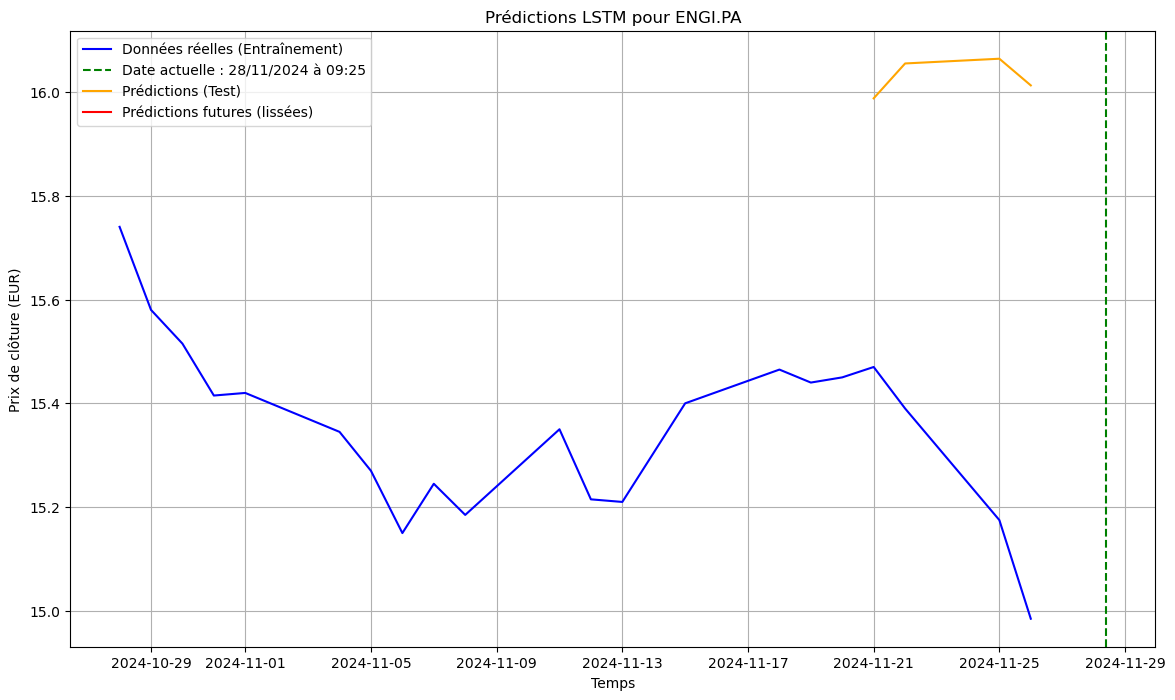

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour VIV.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 8.3221
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 7.8517
Epoch 3/50
1/1 [==============================] - 0s 10ms/step - loss: 7.5099
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 7.1924
Epoch 5/50
1/1 [==============================] - 0s 10ms/step - loss: 6.8689
Epoch 6/50
1/1 [==============================] - 0s 9ms/step - loss: 6.5789
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 6.2841
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 5.8054
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 5.4101
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 4.8900
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 4.3829
Epoch 12/50
1/1 [==============================] - 0s 9ms/step - loss: 3.7168
Epoch 13/50
1/1 [==============================] - 0s 8ms/step - loss: 2

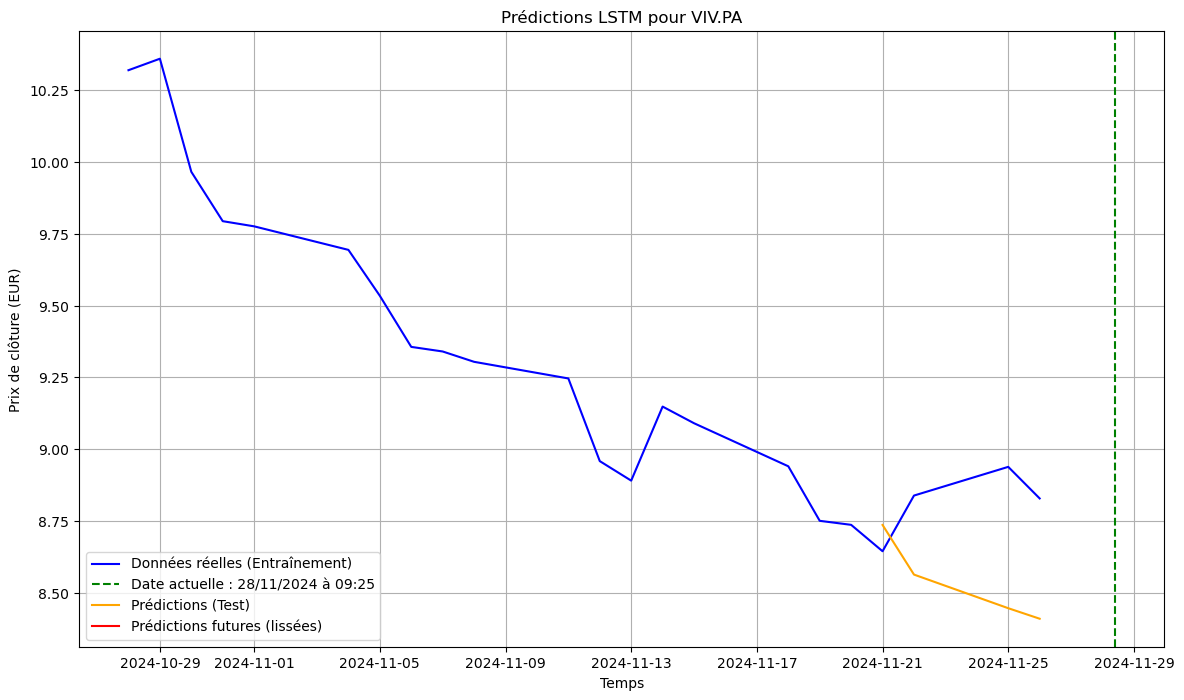

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour SGO.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 93.2873
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 90.9554
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 88.3948
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 86.8888
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 86.4775
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 84.1200
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 82.8007
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 81.0926
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 80.2685
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 79.0530
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 77.7099
Epoch 12/50
1/1 [==============================] - 0s 8ms/step - loss: 76.6476
Epoch 13/50
1/1 [==============================] - 0s 7ms/step

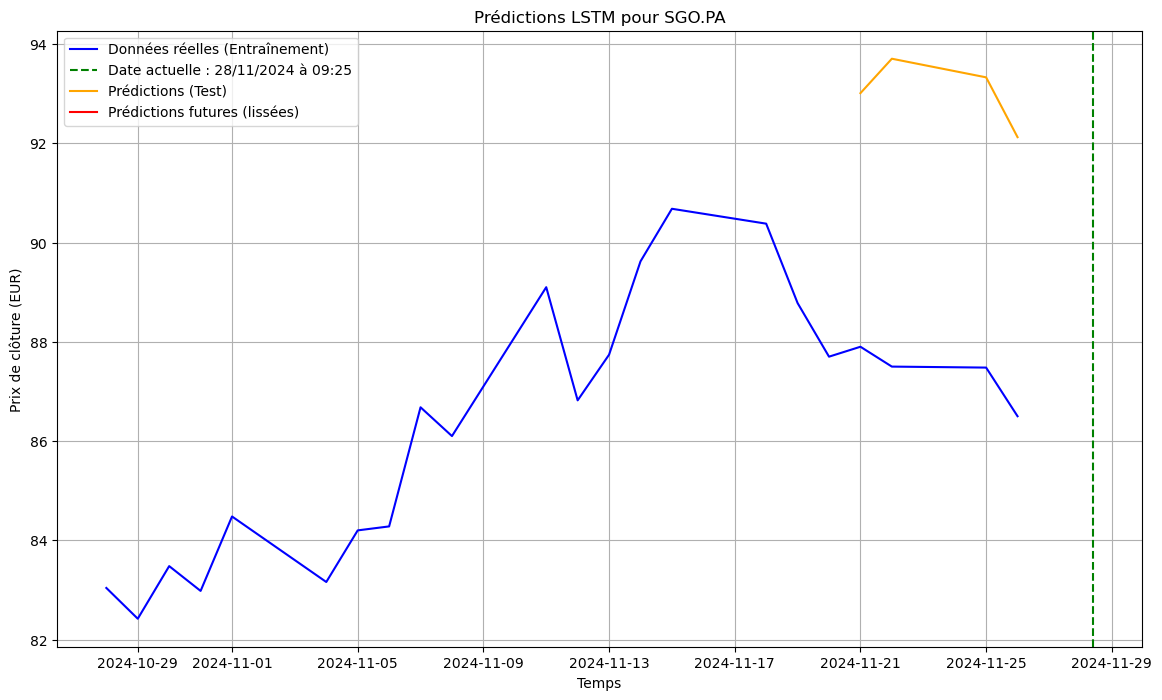

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour CA.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 14.6059
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 13.2230
Epoch 3/50
1/1 [==============================] - 0s 10ms/step - loss: 12.2774
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 11.2761
Epoch 5/50
1/1 [==============================] - 0s 10ms/step - loss: 10.6708
Epoch 6/50
1/1 [==============================] - 0s 10ms/step - loss: 9.3087
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 8.2728
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 7.0468
Epoch 9/50
1/1 [==============================] - 0s 9ms/step - loss: 5.7268
Epoch 10/50
1/1 [==============================] - 0s 9ms/step - loss: 4.6537
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 2.8051
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 0.9094
Epoch 13/50
1/1 [==============================] - 0s 8ms/step - l

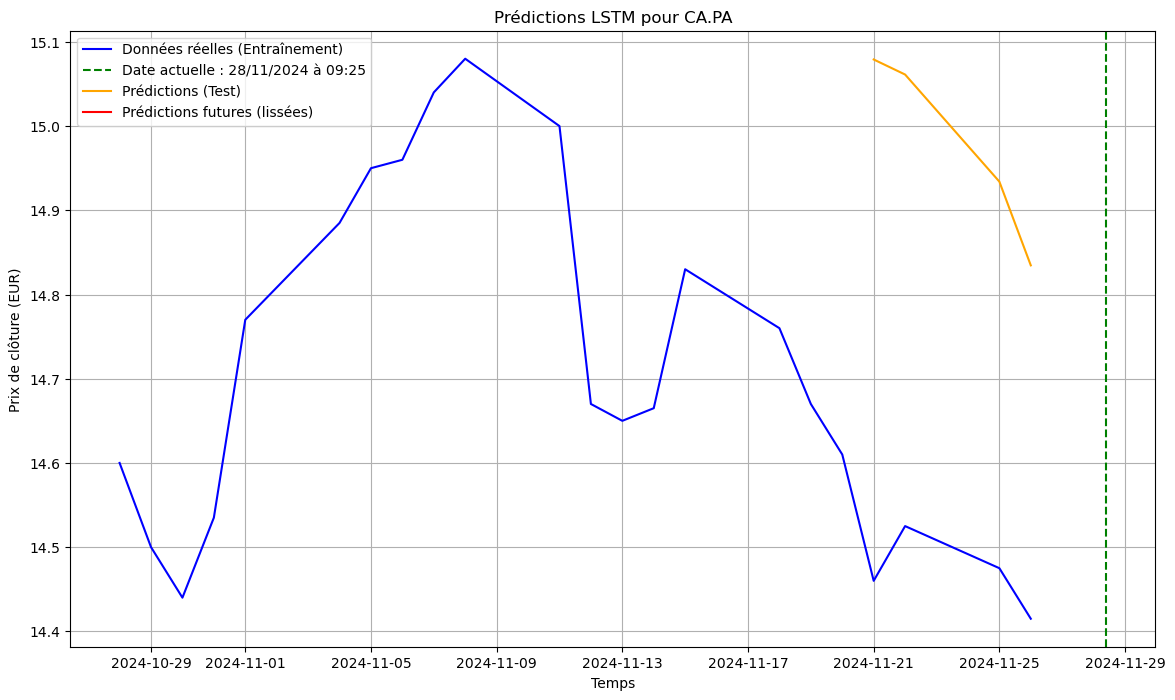

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import tensorflow as tf

# Fonction pour créer le modèle
def create_model(input_shape, units=50, dropout_rate=0.01):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Fonction principale
def main():
    # Liste des tickers pour les actions du CAC 40
    tickers = ['MC.PA', 'OR.PA', 'AIR.PA', 'SAN.PA', 'BNP.PA',
               'GLE.PA', 'ENGI.PA', 'VIV.PA', 'SGO.PA', 'CA.PA']
    train_start_date = '2024-10-27'
    train_end_date = '2024-11-27'
    predict_start_date = '2024-11-28'
    predict_end_date = '2024-12-07'
    interval = '1d'
    current_date = pd.Timestamp('2024-11-28 09:25')  # Date actuelle pour tracer la ligne verte

    for ticker in tickers:
        print(f"\nAnalyse pour {ticker}...\n")
        
        # Télécharger les données pour l'entraînement
        train_data = yf.download(ticker, start=train_start_date, end=train_end_date, interval=interval)
        if train_data.empty:
            print(f"Aucune donnée trouvée pour {ticker}.")
            continue
        
        # Télécharger les données pour les prédictions
        predict_data = yf.download(ticker, start=predict_start_date, end=predict_end_date, interval=interval)
        if predict_data.empty:
            print(f"Aucune donnée trouvée pour les prédictions de {ticker}.")
            continue
        
        # Utiliser uniquement les prix de clôture
        train_close = train_data['Close'].values
        predict_close = predict_data['Close'].values

        # Préparation des données pour LSTM
        time_steps = 5  # Réduction du nombre de pas pour s'adapter aux données journalières
        input_data = []
        labels = []
        for i in range(len(train_close) - time_steps):
            input_data.append(train_close[i:i + time_steps])
            labels.append(train_close[i + time_steps])

        # Conversion en array pour Keras
        input_data = np.array(input_data)
        labels = np.array(labels)

        # Reshape pour le modèle : [samples, time steps, features]
        input_data = np.reshape(input_data, (input_data.shape[0], input_data.shape[1], 1))

        # Séparation en données d'entraînement et de test
        train_size = int(len(input_data) * 0.8)
        x_train, x_test = input_data[:train_size], input_data[train_size:]
        y_train, y_test = labels[:train_size], labels[train_size:]

        # Création et entraînement du modèle
        model = create_model(input_shape=(time_steps, 1))
        model.fit(x_train, y_train, epochs=50, verbose=1)

        # Prédiction sur les données de test
        predictions_test = model.predict(x_test)
        rmse_test = sqrt(mean_squared_error(y_test, predictions_test))
        print(f"RMSE pour l'ensemble de test de {ticker} : {rmse_test}")

        # Prédiction sur les données futures
        prediction_input = train_close[-time_steps:]  # Dernières valeurs pour prédire
        prediction_input = np.reshape(prediction_input, (1, time_steps, 1))  # Reshape pour le modèle
        predictions_future = []

        for _ in range(len(predict_close)):  # Nombre de pas dans les données futures
            pred = model.predict(prediction_input)[0][0]
            predictions_future.append(pred)
            # Reformater pred pour correspondre à (1, 1, 1) avant de l'ajouter à prediction_input
            pred_reshaped = np.array([[[pred]]])  # Transformer le scalaire en 3D
            prediction_input = np.append(prediction_input[:, 1:, :], pred_reshaped, axis=1)

        # Appliquer une moyenne mobile pour lisser les prédictions futures
        smoothed_predictions_future = pd.Series(predictions_future).rolling(window=3).mean()

        # Visualisation des résultats
        plt.figure(figsize=(14, 8))
        
        # Obtenir les dates pour l'axe des abscisses
        train_dates = train_data.index[time_steps:]
        test_dates = train_dates[train_size:]
        predict_dates = predict_data.index
        
        # Graphique des données réelles
        plt.plot(train_data.index, train_close, label='Données réelles (Entraînement)', color='blue')
        
        # Ajouter la ligne de séparation entre entraînement et test
        plt.axvline(x=current_date, color='green', linestyle='--', label='Date actuelle : 28/11/2024 à 09:25')
        
        # Graphique des prédictions sur l'ensemble de test
        test_start_index = len(train_close) - len(x_test)
        plt.plot(train_data.index[test_start_index:], predictions_test, label='Prédictions (Test)', color='orange')

        # Graphique des prédictions futures (lissées)
        plt.plot(predict_dates, smoothed_predictions_future, label='Prédictions futures (lissées)', color='red')
        
        plt.title(f'Prédictions LSTM pour {ticker}')
        plt.xlabel('Temps')
        plt.ylabel('Prix de clôture (EUR)')
        plt.legend()
        plt.grid()
        plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour MC.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 600.8656
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 595.3790
Epoch 3/50
1/1 [==============================] - 0s 10ms/step - loss: 587.9603
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 579.2903
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 570.8091
Epoch 6/50
1/1 [==============================] - 0s 11ms/step - loss: 567.5883
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 562.1913
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 557.5634
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 552.5814
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 533.9302
Epoch 11/50
1/1 [==============================] - 0s 10ms/step - loss: 520.6281
Epoch 12/50
1/1 [==============================] - 0s 9ms/step - loss: 507.9071
Epoch 13/50
1/1 [==============================

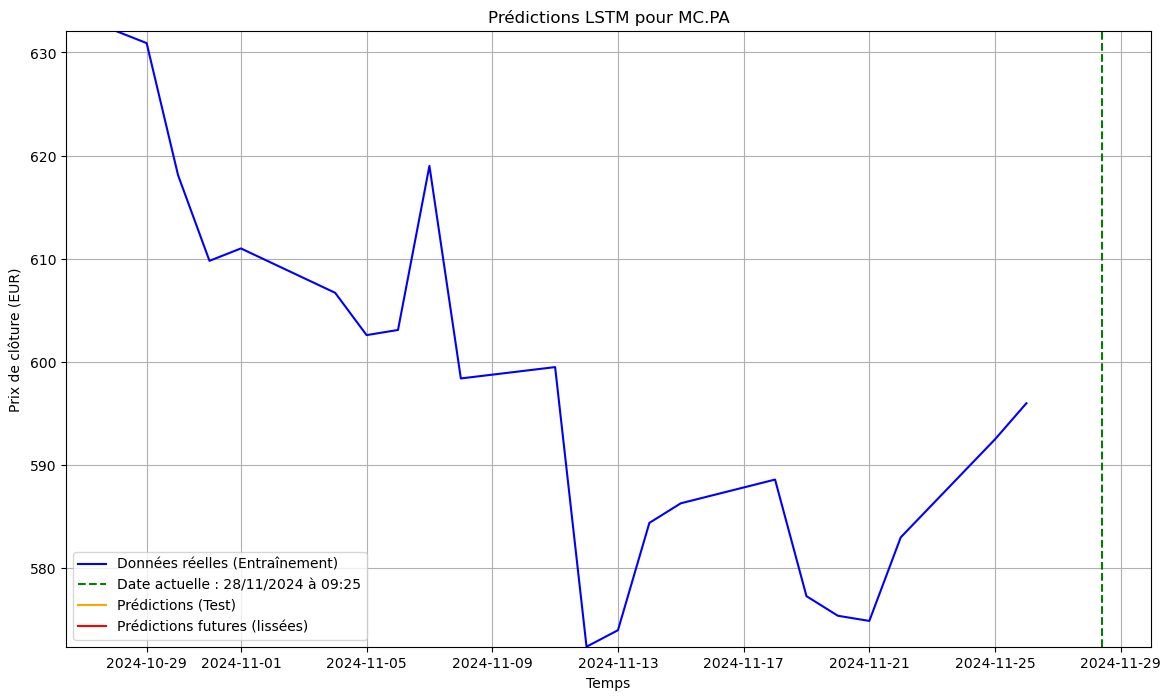

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour OR.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 276.1202
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 252.7532
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 302.8549
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 239.0743
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 235.0565
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 229.6952
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 221.6806
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 217.4954
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 213.3372
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 207.6769
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 201.9179
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 201.6760
Epoch 13/50
1/1 [==============================] -

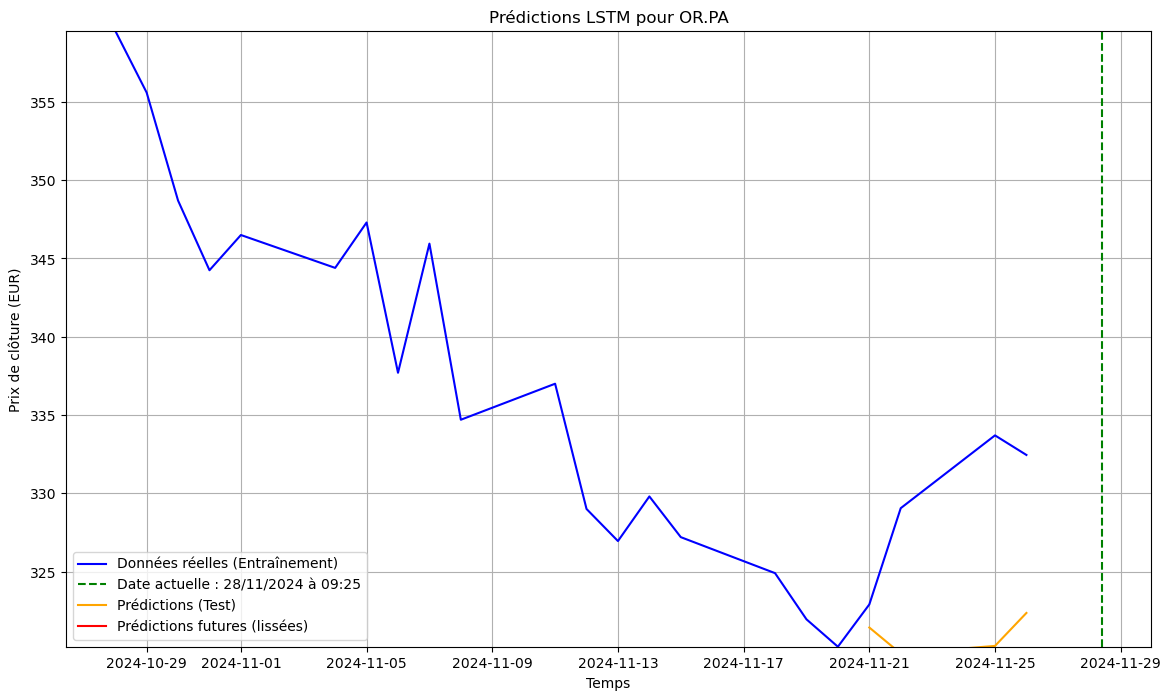

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour AIR.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 122.6485
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 120.3173
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 116.2363
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 114.8232
Epoch 5/50
1/1 [==============================] - 0s 6ms/step - loss: 115.6606
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 112.2337
Epoch 7/50
1/1 [==============================] - 0s 5ms/step - loss: 110.8690
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 108.8375
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 105.9278
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 101.4434
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 94.3429
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 88.6693
Epoch 13/50
1/1 [==============================] - 0

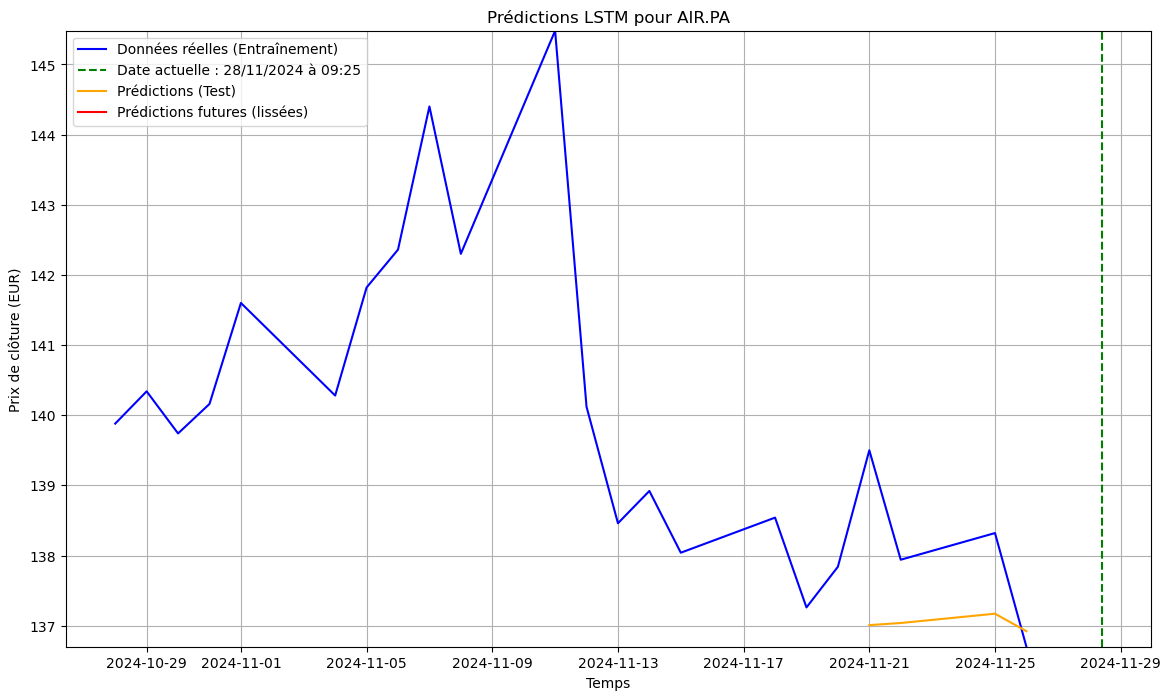

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour SAN.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 87.9647
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 86.0346
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 84.9342
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 84.4293
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 82.4866
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 80.4320
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 77.1410
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 72.1242
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 65.1263
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 59.5395
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 55.5930
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 50.4121
Epoch 13/50
1/1 [==============================] - 0s 8ms/step

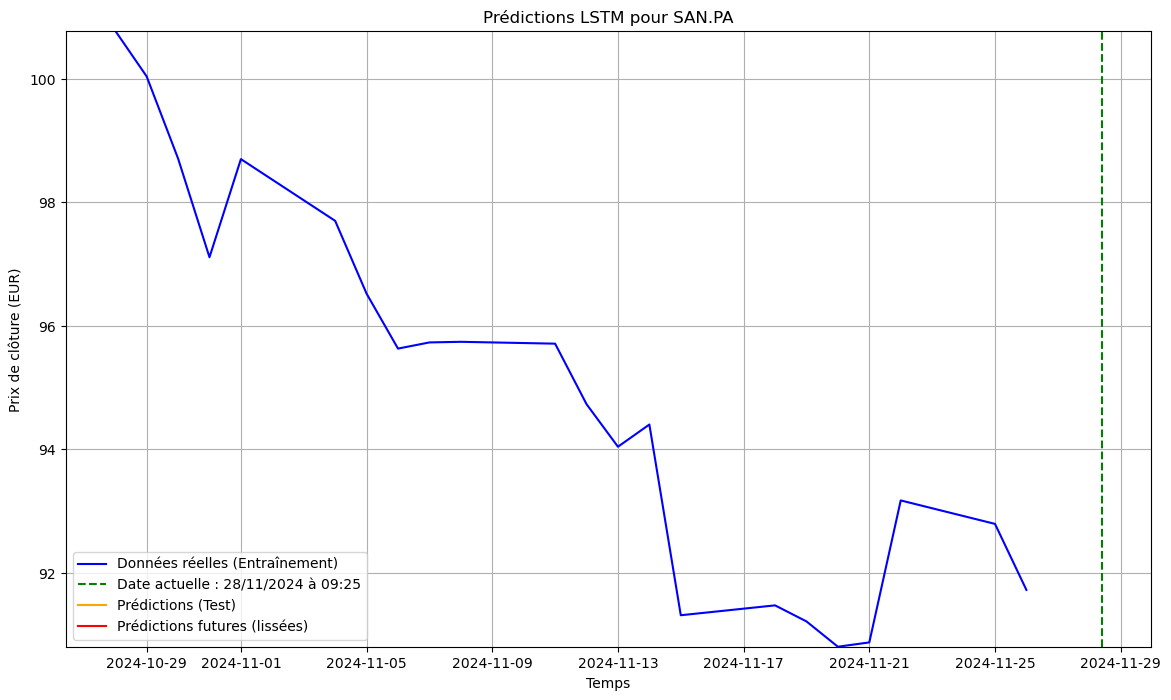

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour BNP.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 64.4480
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 59.1953
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 53.5766
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 46.2741
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 37.1025
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 28.6725
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 15.2880
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 3.8479
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 15.2890
Epoch 10/50
1/1 [==============================] - 0s 5ms/step - loss: 4.3452
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 10.3186
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 3.4227
Epoch 13/50
1/1 [==============================] - 0s 6ms/step - 

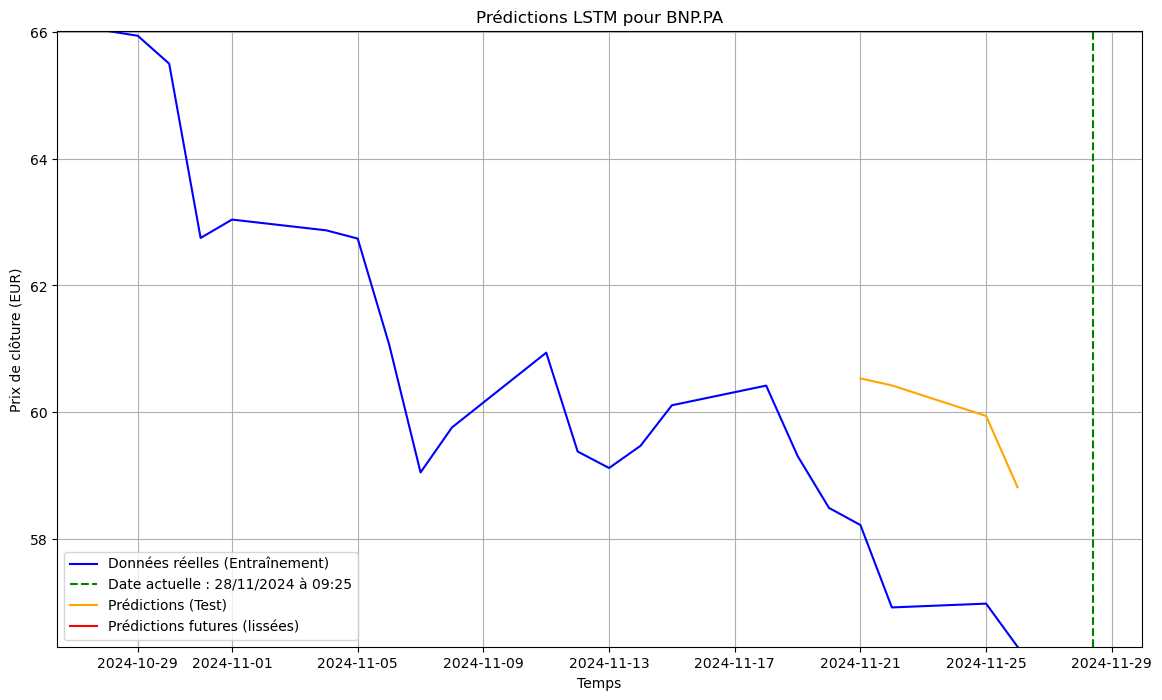

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour GLE.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 26.9333
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 23.7778
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 21.2573
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 19.2437
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 16.9884
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 14.0708
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 10.8685
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 7.0299
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 1.7132
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 5.5516
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 1.9931
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 2.1957
Epoch 13/50
1/1 [==============================] - 0s 6ms/step - lo

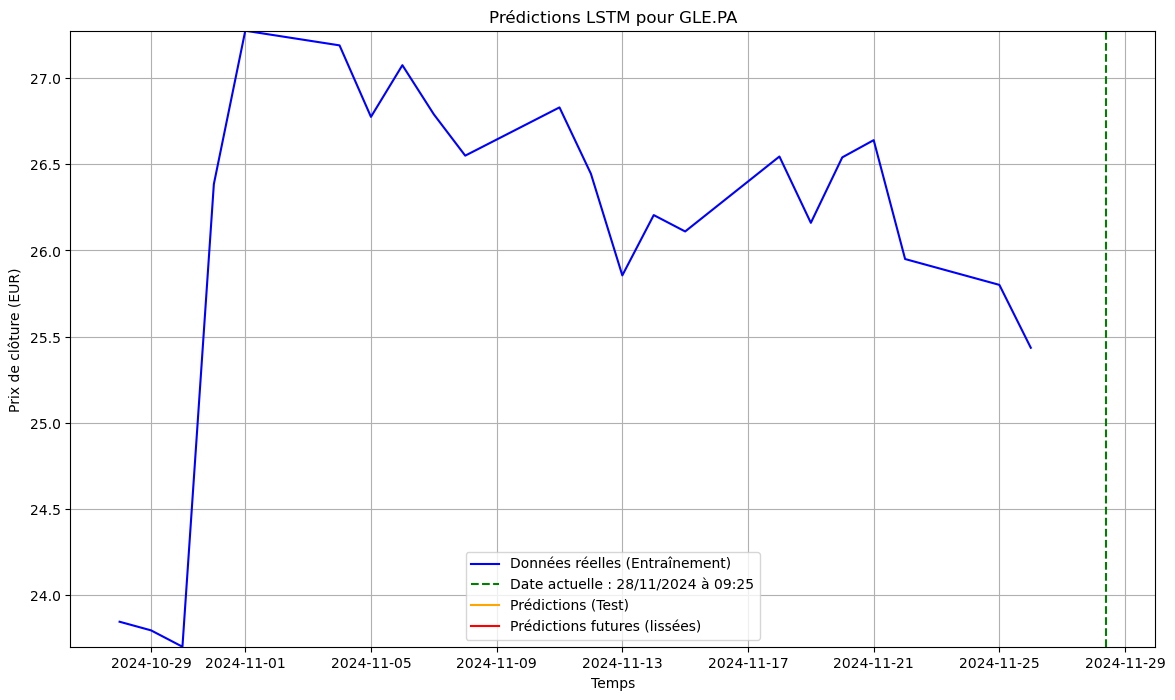

[*********************100%***********************]  1 of 1 completed


Analyse pour ENGI.PA...




[*********************100%***********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 13.8149
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 13.0772
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 12.6314
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 12.1929
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 11.7538
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 11.3120
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 10.7800
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 10.2006
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 9.5267
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 8.7107
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 7.5511
Epoch 12/50
1/1 [==============================] - 0s 8ms/step - loss: 6.0619
Epoch 13/50
1/1 [==============================] - 0s 7ms/step - l

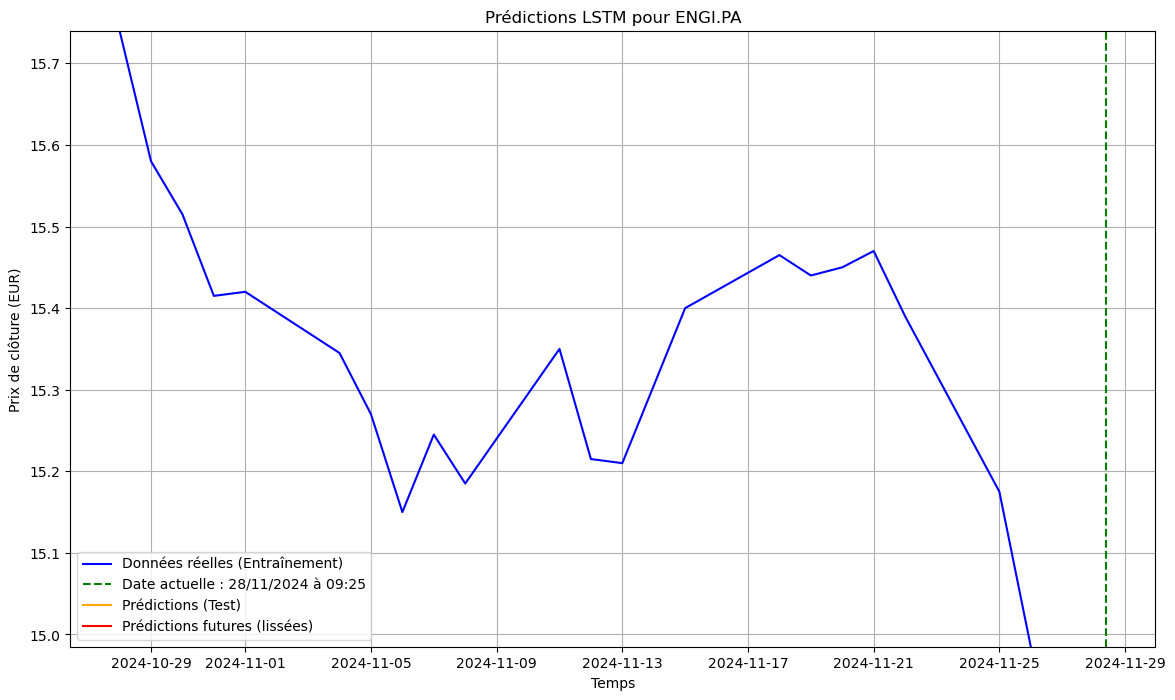

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour VIV.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 9.2937
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 8.6470
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 8.1771
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 7.6881
Epoch 5/50
1/1 [==============================] - 0s 5ms/step - loss: 7.1710
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 6.6429
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 5.9552
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 5.3503
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 4.4864
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 3.3436
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 2.1740
Epoch 12/50
1/1 [==============================] - 0s 8ms/step - loss: 0.6815
Epoch 13/50
1/1 [==============================] - 0s 8ms/step - loss: 1.0

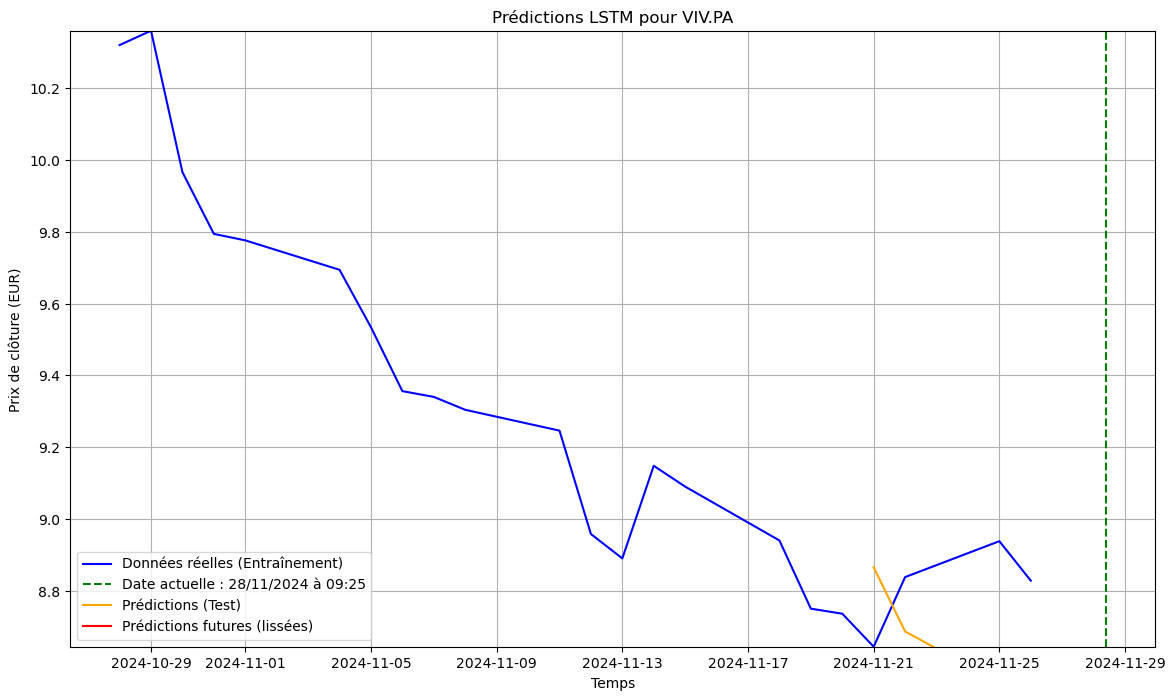

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour SGO.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 84.9442
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 80.4288
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 76.8321
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 74.5517
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 68.4019
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 64.1236
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 60.3631
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 53.3994
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 45.6484
Epoch 10/50
1/1 [==============================] - 0s 6ms/step - loss: 28.5023
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 7.1518
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 8.0845
Epoch 13/50
1/1 [==============================] - 0s 7ms/step -

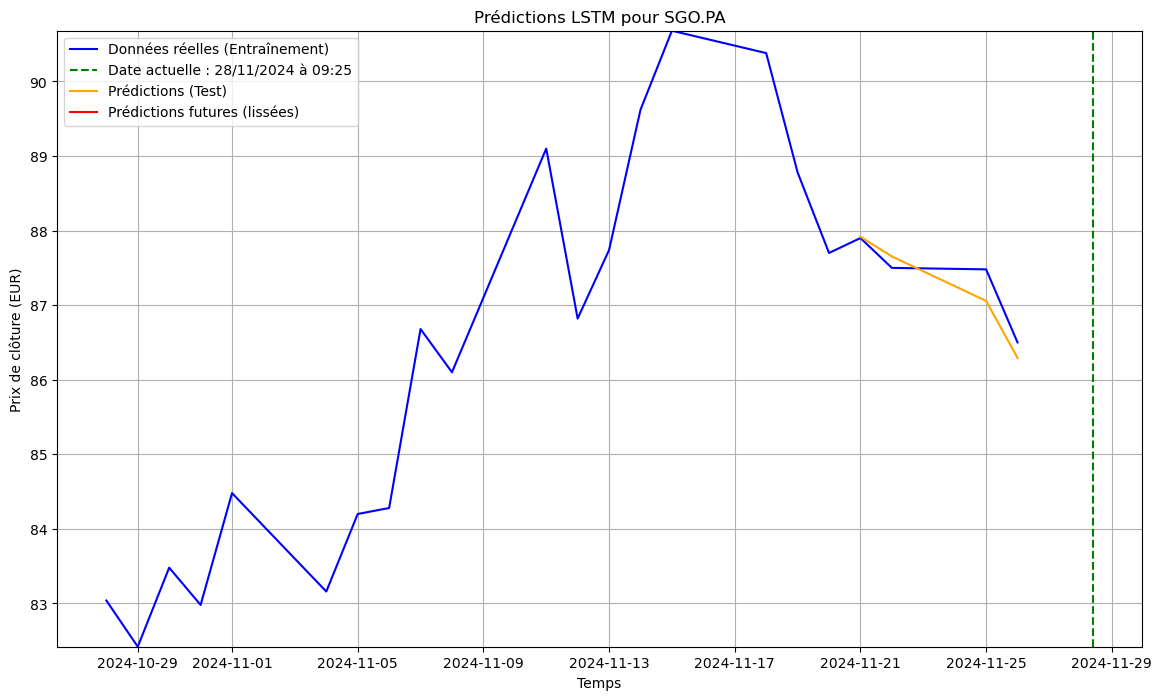

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour CA.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 16.1532
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 15.5834
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 15.1815
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 14.8599
Epoch 5/50
1/1 [==============================] - 0s 6ms/step - loss: 14.4921
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 13.9964
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 13.6454
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 13.3049
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 12.8120
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 12.3755
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 11.8554
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 11.2001
Epoch 13/50
1/1 [==============================] - 0s 6ms/step

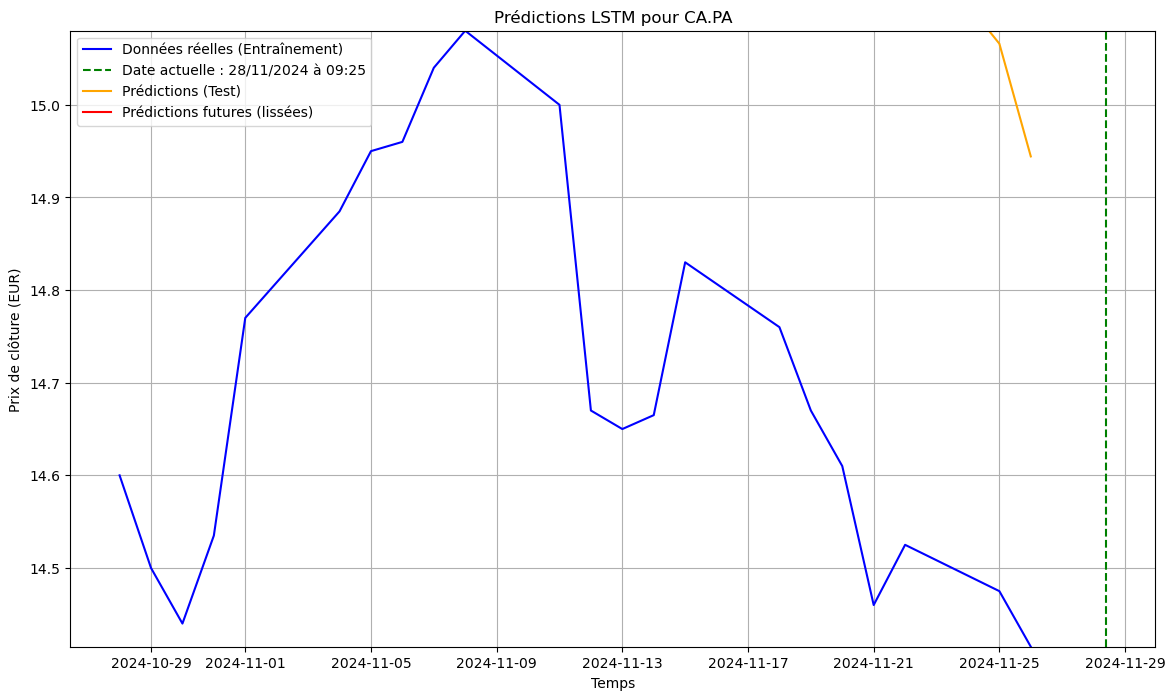

In [5]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import tensorflow as tf

# Fonction pour créer le modèle
def create_model(input_shape, units=50, dropout_rate=0.01):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Fonction principale
def main():
    # Liste des tickers pour les actions du CAC 40
    tickers = ['MC.PA', 'OR.PA', 'AIR.PA', 'SAN.PA', 'BNP.PA',
               'GLE.PA', 'ENGI.PA', 'VIV.PA', 'SGO.PA', 'CA.PA']
    train_start_date = '2024-10-27'
    train_end_date = '2024-11-27'
    predict_start_date = '2024-11-28'
    predict_end_date = '2024-12-07'
    interval = '1d'
    current_date = pd.Timestamp('2024-11-28 09:25')  # Date actuelle pour tracer la ligne verte

    for ticker in tickers:
        print(f"\nAnalyse pour {ticker}...\n")
        
        # Télécharger les données pour l'entraînement
        train_data = yf.download(ticker, start=train_start_date, end=train_end_date, interval=interval)
        if train_data.empty:
            print(f"Aucune donnée trouvée pour {ticker}.")
            continue
        
        # Télécharger les données pour les prédictions
        predict_data = yf.download(ticker, start=predict_start_date, end=predict_end_date, interval=interval)
        if predict_data.empty:
            print(f"Aucune donnée trouvée pour les prédictions de {ticker}.")
            continue
        
        # Utiliser uniquement les prix de clôture
        train_close = train_data['Close'].values
        predict_close = predict_data['Close'].values

        # Préparation des données pour LSTM
        time_steps = 5  # Réduction du nombre de pas pour s'adapter aux données journalières
        input_data = []
        labels = []
        for i in range(len(train_close) - time_steps):
            input_data.append(train_close[i:i + time_steps])
            labels.append(train_close[i + time_steps])

        # Conversion en array pour Keras
        input_data = np.array(input_data)
        labels = np.array(labels)

        # Reshape pour le modèle : [samples, time steps, features]
        input_data = np.reshape(input_data, (input_data.shape[0], input_data.shape[1], 1))

        # Séparation en données d'entraînement et de test
        train_size = int(len(input_data) * 0.8)
        x_train, x_test = input_data[:train_size], input_data[train_size:]
        y_train, y_test = labels[:train_size], labels[train_size:]

        # Création et entraînement du modèle
        model = create_model(input_shape=(time_steps, 1))
        model.fit(x_train, y_train, epochs=50, verbose=1)

        # Prédiction sur les données de test
        predictions_test = model.predict(x_test)
        rmse_test = sqrt(mean_squared_error(y_test, predictions_test))
        print(f"RMSE pour l'ensemble de test de {ticker} : {rmse_test}")

        # Prédiction sur les données futures
        prediction_input = train_close[-time_steps:]  # Dernières valeurs pour prédire
        prediction_input = np.reshape(prediction_input, (1, time_steps, 1))  # Reshape pour le modèle
        predictions_future = []

        for _ in range(len(predict_close)):  # Nombre de pas dans les données futures
            pred = model.predict(prediction_input)[0][0]
            predictions_future.append(pred)
            # Reformater pred pour correspondre à (1, 1, 1) avant de l'ajouter à prediction_input
            pred_reshaped = np.array([[[pred]]])  # Transformer le scalaire en 3D
            prediction_input = np.append(prediction_input[:, 1:, :], pred_reshaped, axis=1)

        # Appliquer une moyenne mobile pour lisser les prédictions futures
        smoothed_predictions_future = pd.Series(predictions_future).rolling(window=3).mean()

        # Visualisation des résultats
        plt.figure(figsize=(14, 8))
        
        # Obtenir les dates pour l'axe des abscisses
        train_dates = train_data.index[time_steps:]
        test_dates = train_dates[train_size:]
        predict_dates = predict_data.index
        
        # Graphique des données réelles
        plt.plot(train_data.index, train_close, label='Données réelles (Entraînement)', color='blue')
        
        # Ajouter la ligne de séparation entre entraînement et test
        plt.axvline(x=current_date, color='green', linestyle='--', label='Date actuelle : 28/11/2024 à 09:25')
        
        # Graphique des prédictions sur l'ensemble de test
        test_start_index = len(train_close) - len(predictions_test)
        plt.plot(train_data.index[test_start_index:], predictions_test, label='Prédictions (Test)', color='orange')

        # Graphique des prédictions futures (lissées)
        plt.plot(predict_dates, smoothed_predictions_future, label='Prédictions futures (lissées)', color='red')
        
        # Ajustement des limites pour afficher toutes les courbes
        plt.ylim(min(train_close.min(), smoothed_predictions_future.min()), max(train_close.max(), smoothed_predictions_future.max()))
        
        plt.title(f'Prédictions LSTM pour {ticker}')
        plt.xlabel('Temps')
        plt.ylabel('Prix de clôture (EUR)')
        plt.legend()
        plt.grid()
        plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour MC.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 529.2530
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 507.0774
Epoch 3/50
1/1 [==============================] - 0s 10ms/step - loss: 497.7652
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 481.6618
Epoch 5/50
1/1 [==============================] - 0s 10ms/step - loss: 471.2144
Epoch 6/50
1/1 [==============================] - 0s 10ms/step - loss: 469.9766
Epoch 7/50
1/1 [==============================] - 0s 9ms/step - loss: 443.2476
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 432.0122
Epoch 9/50
1/1 [==============================] - 0s 10ms/step - loss: 425.5887
Epoch 10/50
1/1 [==============================] - 0s 11ms/step - loss: 428.1679
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 412.6901
Epoch 12/50
1/1 [==============================] - 0s 9ms/step - loss: 404.9970
Epoch 13/50
1/1 [============================

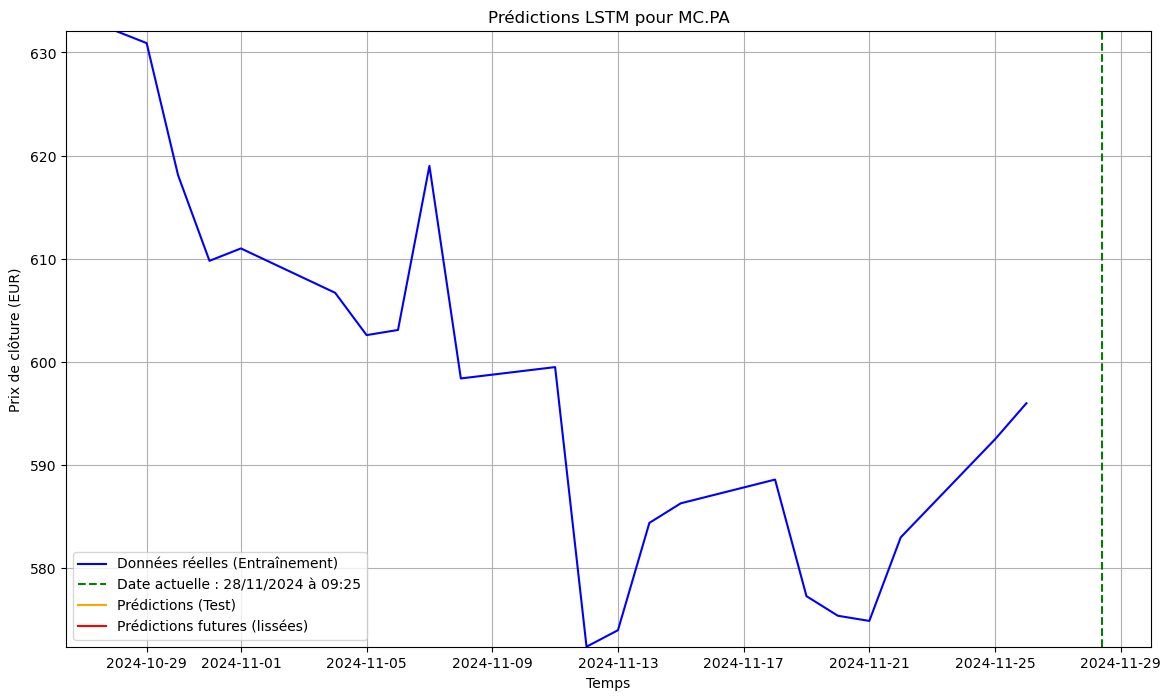

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour OR.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 459.2632
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 431.7426
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 413.7886
Epoch 4/50
1/1 [==============================] - 0s 10ms/step - loss: 404.7730
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 397.7110
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 392.7366
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 394.6511
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 378.9389
Epoch 9/50
1/1 [==============================] - 0s 9ms/step - loss: 371.0807
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 365.6025
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 359.8843
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 347.3724
Epoch 13/50
1/1 [==============================] 

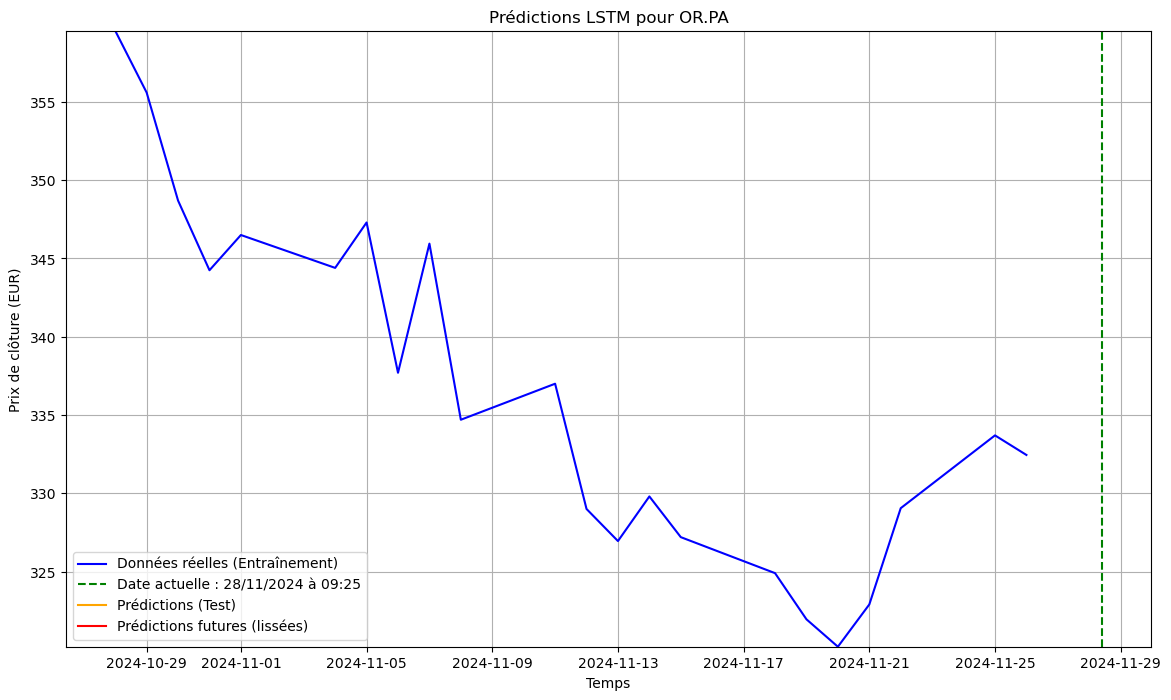

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour AIR.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 132.0558
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 124.0793
Epoch 3/50
1/1 [==============================] - 0s 11ms/step - loss: 118.4503
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 111.8575
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 99.4841
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 90.0023
Epoch 7/50
1/1 [==============================] - 0s 9ms/step - loss: 75.6369
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 71.6137
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 67.0714
Epoch 10/50
1/1 [==============================] - 0s 9ms/step - loss: 58.6882
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 41.2739
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 31.0283
Epoch 13/50
1/1 [==============================] - 0s 6ms

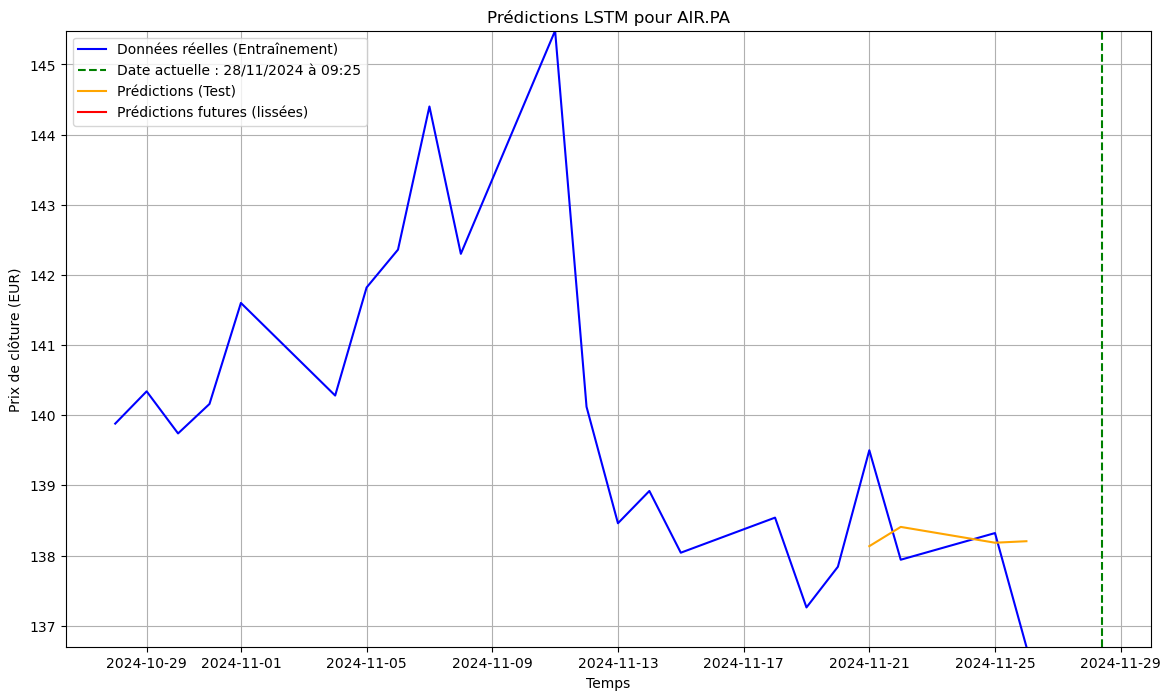

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour SAN.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 96.1267
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 95.1662
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 94.3943
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 93.8494
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 93.4393
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 93.1124
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 92.7665
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 92.4157
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 92.0297
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 91.5456
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 90.8021
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 89.2788
Epoch 13/50
1/1 [==============================] - 0s 6ms/step

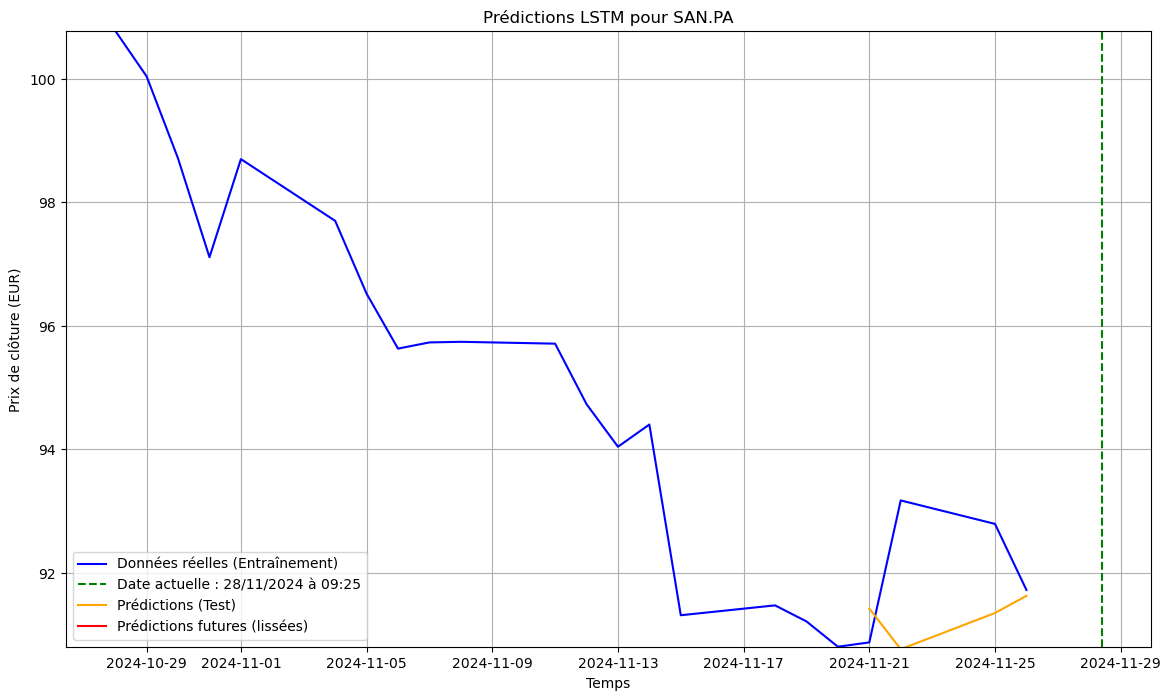

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour BNP.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 58.4226
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 54.0805
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 52.1664
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 48.5087
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 42.5650
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 34.9065
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 26.3349
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 17.6915
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 7.5949
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 4.8388
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 4.7834
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 3.9640
Epoch 13/50
1/1 [==============================] - 0s 8ms/step - l

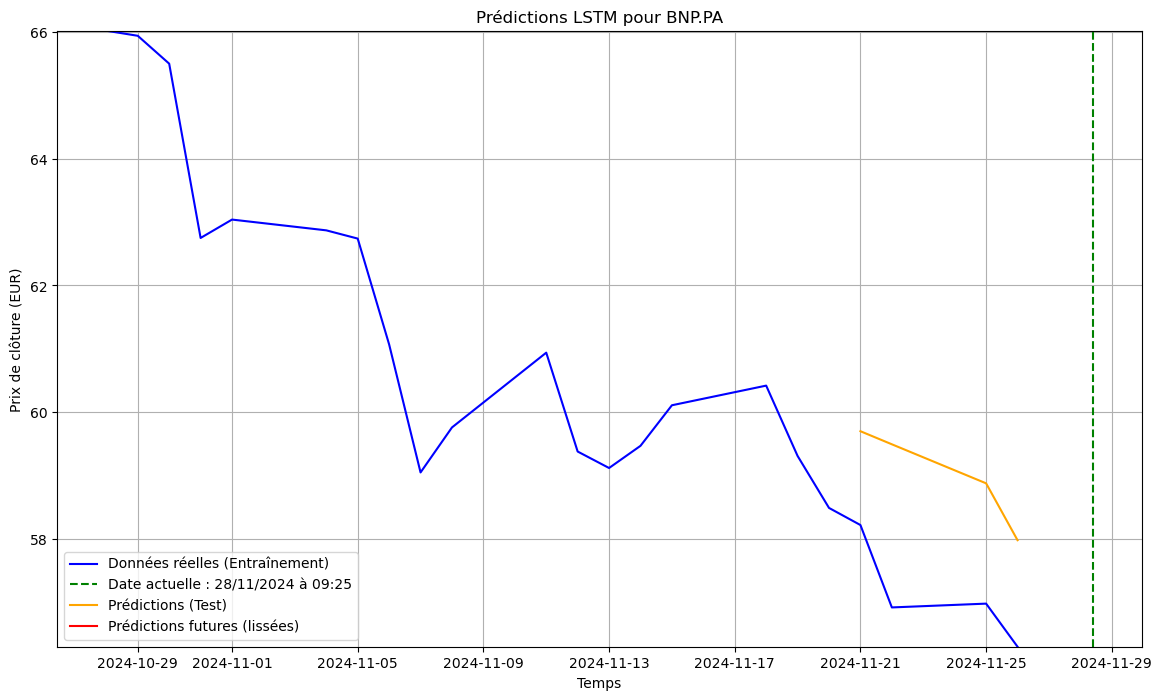

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour GLE.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 26.7273
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 26.2903
Epoch 3/50
1/1 [==============================] - 0s 10ms/step - loss: 25.9843
Epoch 4/50
1/1 [==============================] - 0s 10ms/step - loss: 25.6700
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 25.3626
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 25.1198
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 24.7382
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 24.3564
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 24.0304
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 23.5151
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 22.9876
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 22.3709
Epoch 13/50
1/1 [==============================] - 0s 6ms/st

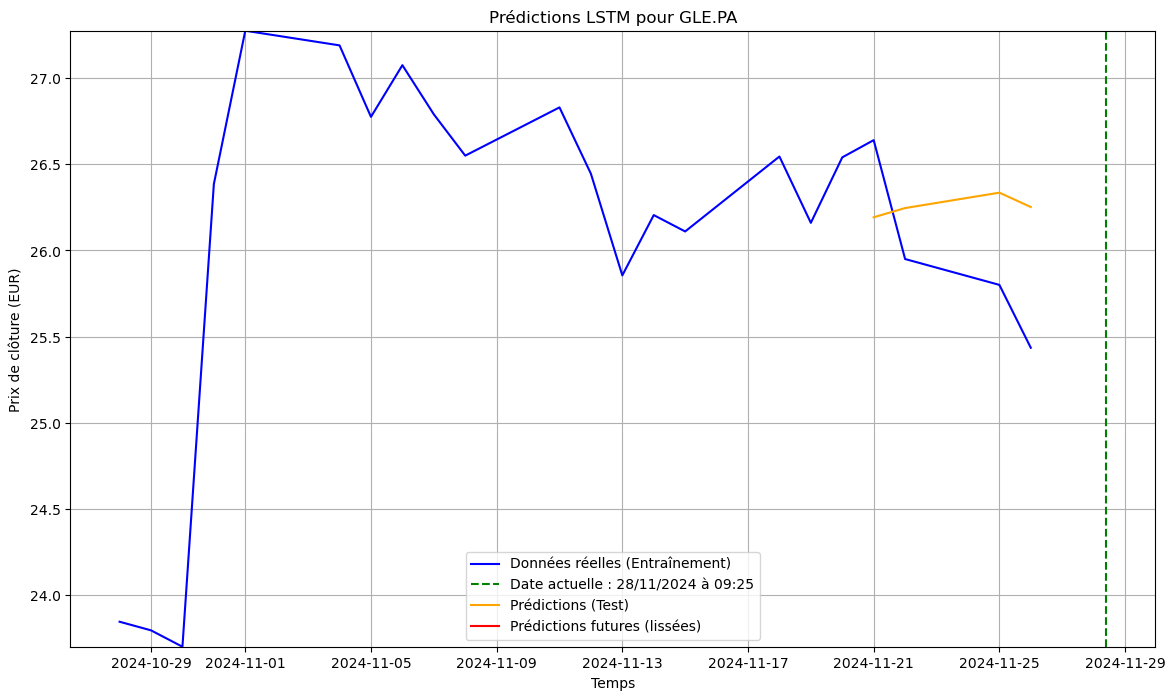

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour ENGI.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 15.2775
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 14.7148
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 14.0140
Epoch 4/50
1/1 [==============================] - 0s 11ms/step - loss: 13.2170
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 12.6671
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 11.7941
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 10.4898
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 9.2270
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 7.4991
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 5.4233
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 3.2955
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 0.5442
Epoch 13/50
1/1 [==============================] - 0s 8ms/step - l

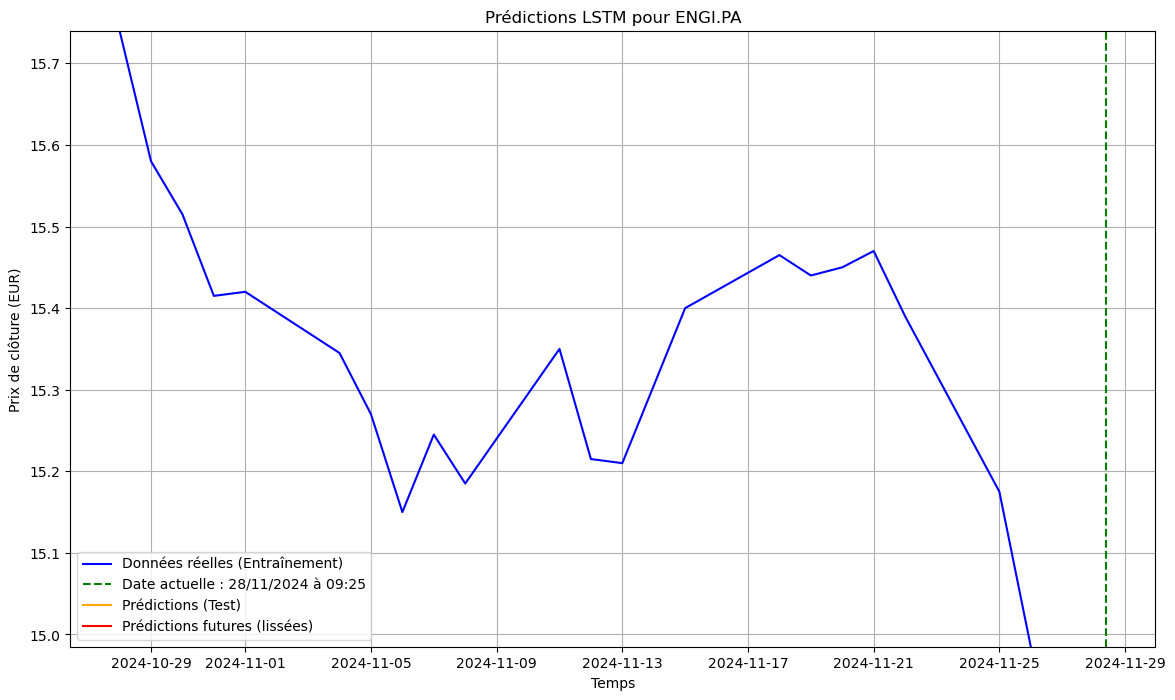

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour VIV.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 9.5908
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 9.3792
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 9.2281
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 9.0831
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 9.0047
Epoch 6/50
1/1 [==============================] - 0s 7ms/step - loss: 8.8951
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 8.7890
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 8.6761
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 8.5827
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 8.5415
Epoch 11/50
1/1 [==============================] - 0s 7ms/step - loss: 8.3799
Epoch 12/50
1/1 [==============================] - 0s 8ms/step - loss: 8.2776
Epoch 13/50
1/1 [==============================] - 0s 7ms/step - loss: 8.1

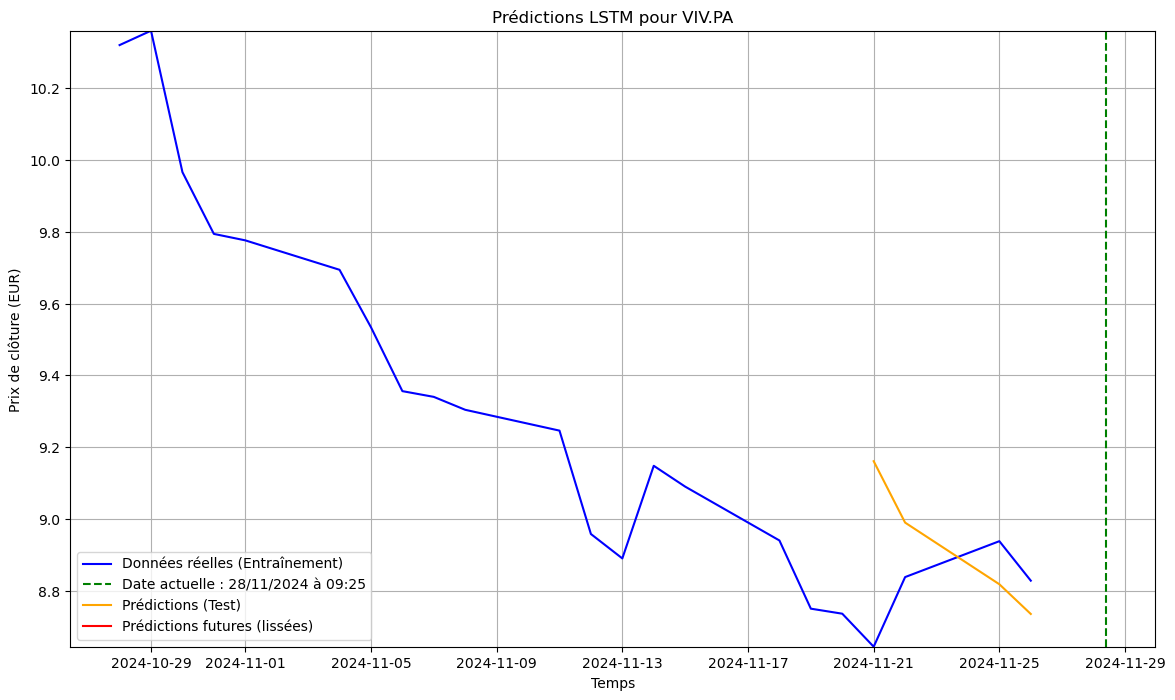

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour SGO.PA...



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 83.7050
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 81.3866
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 79.4613
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 76.3070
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 72.2968
Epoch 6/50
1/1 [==============================] - 0s 9ms/step - loss: 67.7848
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 63.3240
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 58.0661
Epoch 9/50
1/1 [==============================] - 0s 9ms/step - loss: 50.6673
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 41.2642
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 23.8069
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 7.8774
Epoch 13/50
1/1 [==============================] - 0s 8ms/step 

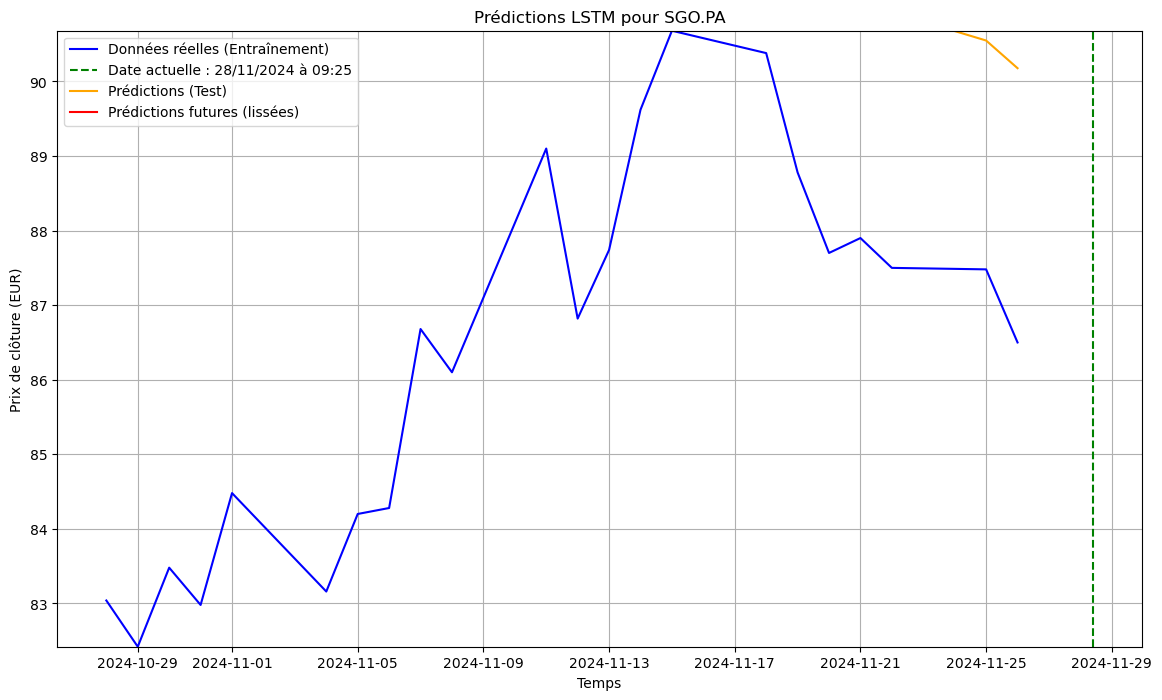

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyse pour CA.PA...



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 15.2204
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 14.2433
Epoch 3/50
1/1 [==============================] - 0s 7ms/step - loss: 13.5231
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 12.7438
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 11.8782
Epoch 6/50
1/1 [==============================] - 0s 9ms/step - loss: 10.7438
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 9.4134
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 7.6366
Epoch 9/50
1/1 [==============================] - 0s 7ms/step - loss: 4.9998
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 1.2301
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 3.7290
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 1.3065
Epoch 13/50
1/1 [==============================] - 0s 7ms/step - los

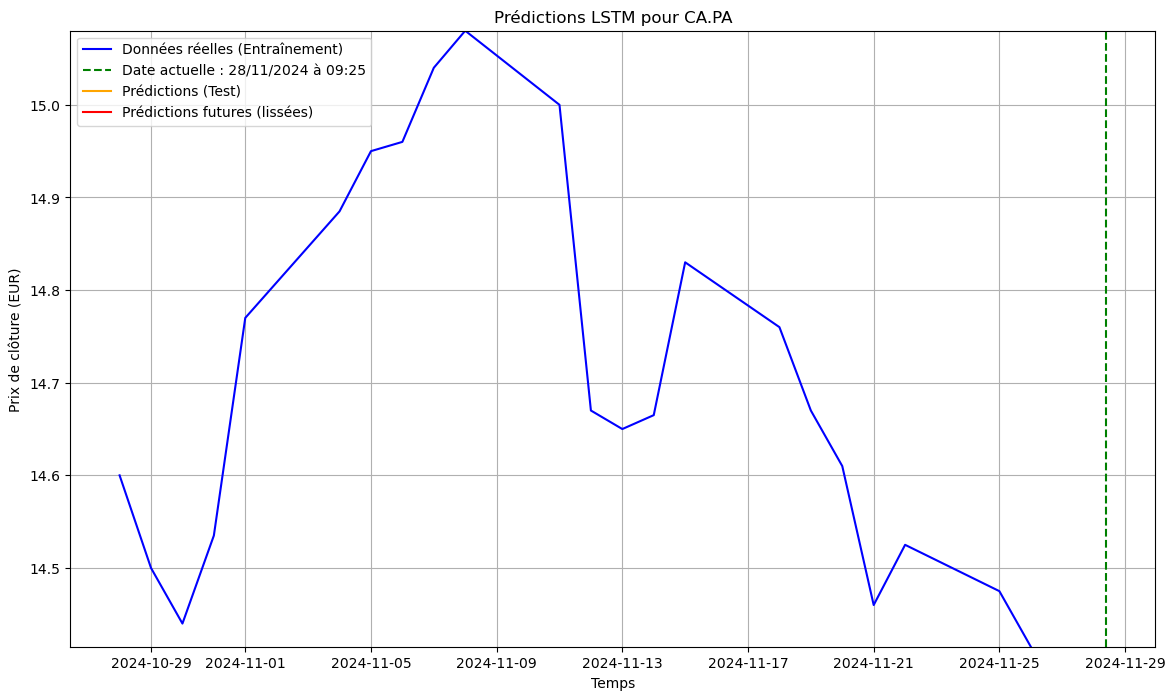

In [6]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import tensorflow as tf

# Fonction pour créer le modèle
def create_model(input_shape, units=50, dropout_rate=0.01):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Fonction principale
def main():
    # Liste des tickers pour les actions du CAC 40
    tickers = ['MC.PA', 'OR.PA', 'AIR.PA', 'SAN.PA', 'BNP.PA',
               'GLE.PA', 'ENGI.PA', 'VIV.PA', 'SGO.PA', 'CA.PA']
    train_start_date = '2024-10-27'
    train_end_date = '2024-11-27'
    predict_start_date = '2024-11-28'
    predict_end_date = '2024-12-07'
    interval = '1d'
    current_date = pd.Timestamp('2024-11-28 09:25')  # Date actuelle pour tracer la ligne verte

    for ticker in tickers:
        print(f"\nAnalyse pour {ticker}...\n")
        
        # Télécharger les données pour l'entraînement
        train_data = yf.download(ticker, start=train_start_date, end=train_end_date, interval=interval)
        if train_data.empty:
            print(f"Aucune donnée trouvée pour {ticker}.")
            continue
        
        # Télécharger les données pour les prédictions
        predict_data = yf.download(ticker, start=predict_start_date, end=predict_end_date, interval=interval)
        if predict_data.empty:
            print(f"Aucune donnée trouvée pour les prédictions de {ticker}.")
            continue
        
        # Utiliser uniquement les prix de clôture
        train_close = train_data['Close'].values
        predict_close = predict_data['Close'].values

        # Préparation des données pour LSTM
        time_steps = 5  # Réduction du nombre de pas pour s'adapter aux données journalières
        input_data = []
        labels = []
        for i in range(len(train_close) - time_steps):
            input_data.append(train_close[i:i + time_steps])
            labels.append(train_close[i + time_steps])

        # Conversion en array pour Keras
        input_data = np.array(input_data)
        labels = np.array(labels)

        # Reshape pour le modèle : [samples, time steps, features]
        input_data = np.reshape(input_data, (input_data.shape[0], input_data.shape[1], 1))

        # Séparation en données d'entraînement et de test
        train_size = int(len(input_data) * 0.8)
        x_train, x_test = input_data[:train_size], input_data[train_size:]
        y_train, y_test = labels[:train_size], labels[train_size:]

        # Création et entraînement du modèle
        model = create_model(input_shape=(time_steps, 1))
        model.fit(x_train, y_train, epochs=50, verbose=1)

        # Prédiction sur les données de test
        predictions_test = model.predict(x_test)
        rmse_test = sqrt(mean_squared_error(y_test, predictions_test))
        print(f"RMSE pour l'ensemble de test de {ticker} : {rmse_test}")

        # Prédiction sur les données futures
        prediction_input = train_close[-time_steps:]  # Dernières valeurs pour prédire
        prediction_input = np.reshape(prediction_input, (1, time_steps, 1))  # Reshape pour le modèle
        predictions_future = []

        for _ in range(len(predict_close)):  # Nombre de pas dans les données futures
            pred = model.predict(prediction_input)[0][0]
            predictions_future.append(pred)
            # Reformater pred pour correspondre à (1, 1, 1) avant de l'ajouter à prediction_input
            pred_reshaped = np.array([[[pred]]])  # Transformer le scalaire en 3D
            prediction_input = np.append(prediction_input[:, 1:, :], pred_reshaped, axis=1)

        # Appliquer une moyenne mobile pour lisser les prédictions futures
        smoothed_predictions_future = pd.Series(predictions_future).rolling(window=3).mean()

        # Visualisation des résultats
        plt.figure(figsize=(14, 8))
        
        # Obtenir les dates pour l'axe des abscisses
        train_dates = train_data.index[time_steps:]
        test_dates = train_dates[train_size:]
        predict_dates = predict_data.index
        
        # Graphique des données réelles
        plt.plot(train_data.index, train_close, label='Données réelles (Entraînement)', color='blue')
        
        # Ajouter la ligne de séparation entre entraînement et test
        plt.axvline(x=current_date, color='green', linestyle='--', label='Date actuelle : 28/11/2024 à 09:25')
        
        # Graphique des prédictions sur l'ensemble de test
        test_start_index = len(train_close) - len(predictions_test)
        plt.plot(train_data.index[test_start_index:], predictions_test, label='Prédictions (Test)', color='orange')

        # Graphique des prédictions futures (lissées)
        plt.plot(predict_dates, smoothed_predictions_future, label='Prédictions futures (lissées)', color='red')
        
        # Ajustement des limites pour afficher toutes les courbes
        plt.ylim(min(train_close.min(), smoothed_predictions_future.min()), max(train_close.max(), smoothed_predictions_future.max()))
        
        plt.title(f'Prédictions LSTM pour {ticker}')
        plt.xlabel('Temps')
        plt.ylabel('Prix de clôture (EUR)')
        plt.legend()
        plt.grid()
        plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
31/31 [==============================] - 9s 84ms/step - loss: 0.0261 - val_loss: 0.0036
Epoch 2/10
31/31 [==============================] - 1s 34ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 3/10
31/31 [==============================] - 1s 36ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 4/10
31/31 [==============================] - 1s 36ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 6/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 8/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 10/10
1/1 [==============================] - 0s 40ms/step


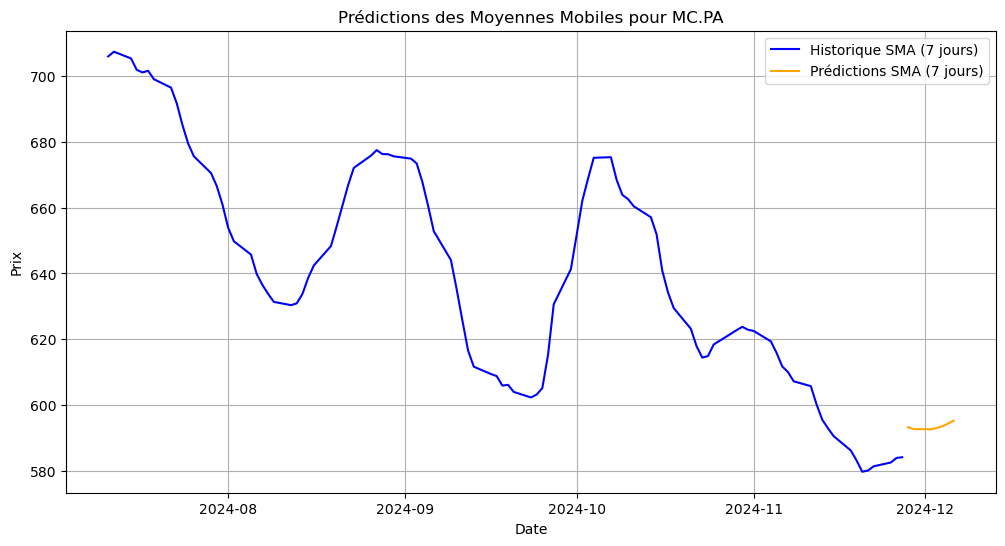

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Récupération des données
ticker = "MC.PA"
data = yf.download(ticker, start="2020-01-01", end="2024-11-28")
data["SMA"] = data["Close"].rolling(window=7).mean()  # Moyenne mobile sur 7 jours

# Prétraitement des données
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data["SMA"].dropna().values.reshape(-1, 1))

# Création des séquences pour LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(data_scaled, sequence_length)

# Division des données en entraînement et test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construction du modèle LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Prédiction pour les 7 prochains jours
last_sequence = data_scaled[-sequence_length:]
predictions = []

for _ in range(7):
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions.append(pred[0][0])
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inversion de la normalisation
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data["SMA"].iloc[-100:], label="Historique SMA (7 jours)", color="blue")
future_dates = pd.date_range(start=data.index[-1], periods=8, freq="B")[1:]  # Jours ouvrés
plt.plot(future_dates, predictions, label="Prédictions SMA (7 jours)", color="orange")
plt.title(f"Prédictions des Moyennes Mobiles pour {ticker}")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()


Epoch 1/50
60/60 [==============================] - 19s 135ms/step - loss: 0.2370 - val_loss: 0.1294
Epoch 2/50
60/60 [==============================] - 6s 104ms/step - loss: 0.0989 - val_loss: 0.0740
Epoch 3/50
60/60 [==============================] - 6s 99ms/step - loss: 0.0616 - val_loss: 0.0473
Epoch 4/50
60/60 [==============================] - 6s 101ms/step - loss: 0.0432 - val_loss: 0.0370
Epoch 5/50
60/60 [==============================] - 6s 106ms/step - loss: 0.0327 - val_loss: 0.0301
Epoch 6/50
60/60 [==============================] - 7s 118ms/step - loss: 0.0265 - val_loss: 0.0236
Epoch 7/50
60/60 [==============================] - 8s 128ms/step - loss: 0.0219 - val_loss: 0.0207
Epoch 8/50
60/60 [==============================] - 6s 98ms/step - loss: 0.0173 - val_loss: 0.0154
Epoch 9/50
60/60 [==============================] - 6s 103ms/step - loss: 0.0148 - val_loss: 0.0135
Epoch 10/50
60/60 [==============================] - 6s 105ms/step - loss: 0.0124 - val_loss: 0.0124


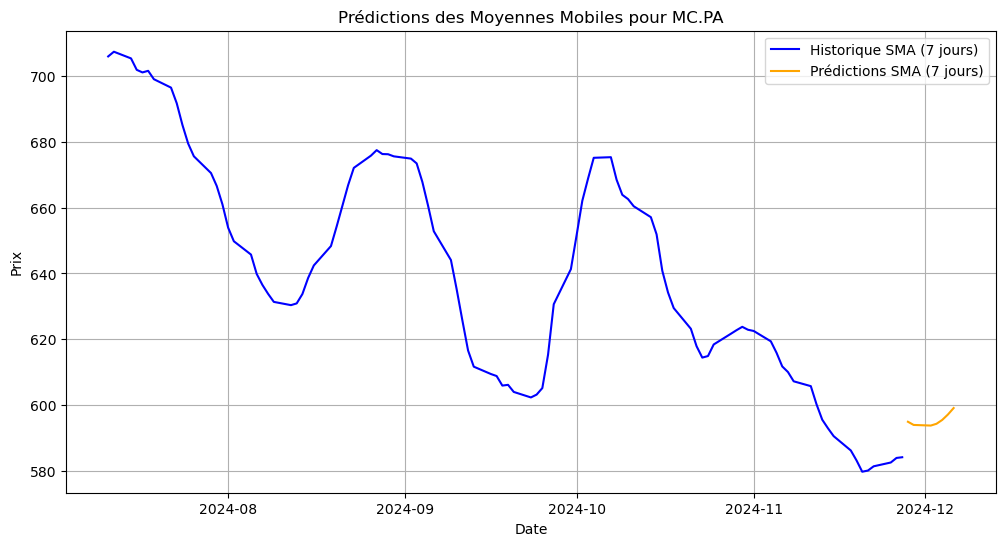

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Augmentation de la séquence
sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# Répartition des données
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construction d'un modèle LSTM plus complexe
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Optimiseur avec un taux d'apprentissage réduit
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping pour arrêter l'entraînement si le modèle ne s'améliore plus
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Prédiction sur les 7 prochains jours
last_sequence = data_scaled[-sequence_length:]
predictions = []

for _ in range(7):
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions.append(pred[0][0])
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inversion de la normalisation
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data["SMA"].iloc[-100:], label="Historique SMA (7 jours)", color="blue")
future_dates = pd.date_range(start=data.index[-1], periods=8, freq="B")[1:]  # Jours ouvrés
plt.plot(future_dates, predictions, label="Prédictions SMA (7 jours)", color="orange")
plt.title(f"Prédictions des Moyennes Mobiles pour {ticker}")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()


Processing OR.PA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
60/60 [==============================] - 12s 100ms/step - loss: 0.0199 - val_loss: 0.0021
Epoch 2/50
60/60 [==============================] - 4s 61ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 3/50
60/60 [==============================] - 4s 60ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 4/50
60/60 [==============================] - 4s 63ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 5/50
60/60 [==============================] - 4s 67ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 6/50
60/60 [==============================] - 4s 65ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 7/50
60/60 [==============================] - 5s 76ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/50
60/60 [==============================] - 5s 78ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 9/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 10/50
60/60 [==============================] - 4s 72ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 1

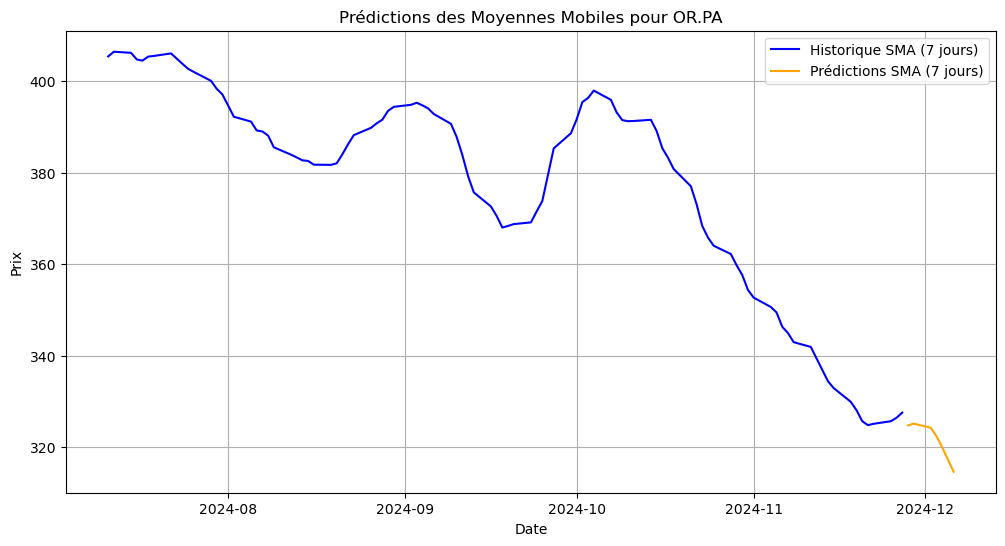

Processing AIR.PA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
60/60 [==============================] - 14s 103ms/step - loss: 0.0148 - val_loss: 0.0011
Epoch 2/50
60/60 [==============================] - 5s 76ms/step - loss: 0.0035 - val_loss: 0.0086
Epoch 3/50
60/60 [==============================] - 5s 82ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 4/50
60/60 [==============================] - 5s 82ms/step - loss: 0.0023 - val_loss: 8.2357e-04
Epoch 5/50
60/60 [==============================] - 5s 76ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 6/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 8/50
60/60 [==============================] - 5s 75ms/step - loss: 0.0018 - val_loss: 6.1664e-04
Epoch 9/50
60/60 [==============================] - 5s 76ms/step - loss: 0.0014 - val_loss: 0.0075
Epoch 10/50
60/60 [==============================] - 5s 83ms/step - loss: 0.0014 - val_loss: 7.7824

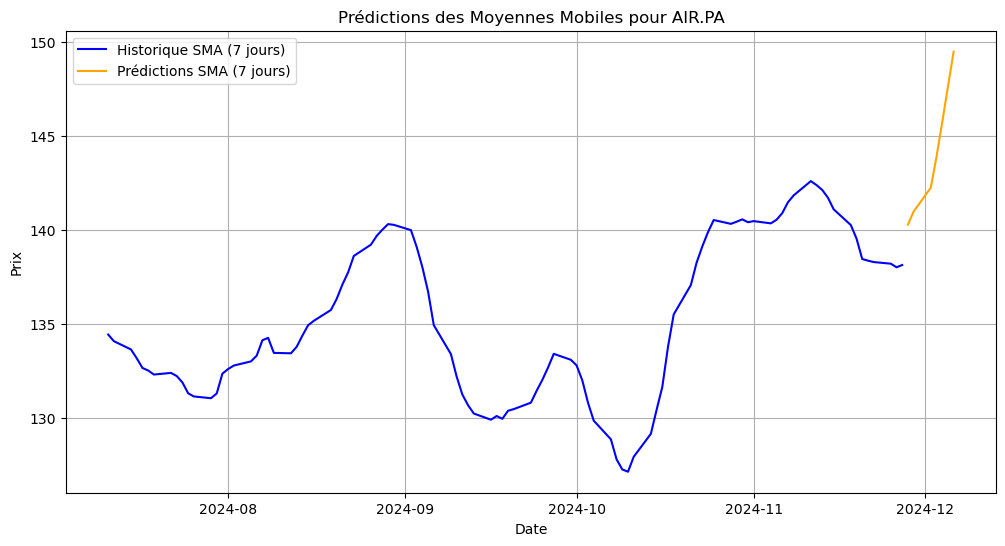

[*********************100%***********************]  1 of 1 completed

Processing SAN.PA...


Epoch 1/50
60/60 [==============================] - 13s 107ms/step - loss: 0.0226 - val_loss: 0.0038
Epoch 2/50
60/60 [==============================] - 5s 78ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 3/50
60/60 [==============================] - 5s 76ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 4/50
60/60 [==============================] - 5s 89ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 5/50
60/60 [==============================] - 7s 109ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 6/50
60/60 [==============================] - 6s 99ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 7/50
60/60 [==============================] - 5s 90ms/step - loss: 0.0038 - val_loss: 9.6699e-04
Epoch 8/50
60/60 [==============================] - 7s 117ms/step - loss: 0.0028 - val_loss: 8.8867e-04
Epoch 9/50
60/60 [==============================] - 6s 91ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 10/50
60/60 [==============================] - 6s 94ms/step - loss: 0.0024 - val_loss: 7.48

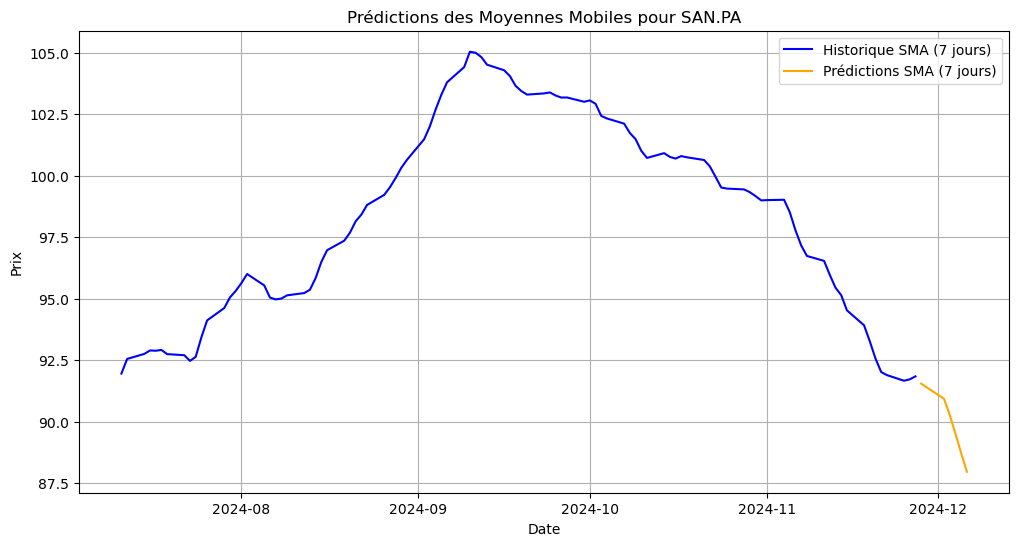

Processing BNP.PA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
60/60 [==============================] - 15s 100ms/step - loss: 0.0240 - val_loss: 0.0019
Epoch 2/50
60/60 [==============================] - 5s 82ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 3/50
60/60 [==============================] - 5s 90ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 4/50
60/60 [==============================] - 5s 83ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 5/50
60/60 [==============================] - 5s 82ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 6/50
60/60 [==============================] - 6s 98ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 7/50
60/60 [==============================] - 6s 95ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 8/50
60/60 [==============================] - 5s 86ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 9/50
60/60 [==============================] - 5s 89ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 10/50
60/60 [==============================] - 5s 84ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 1

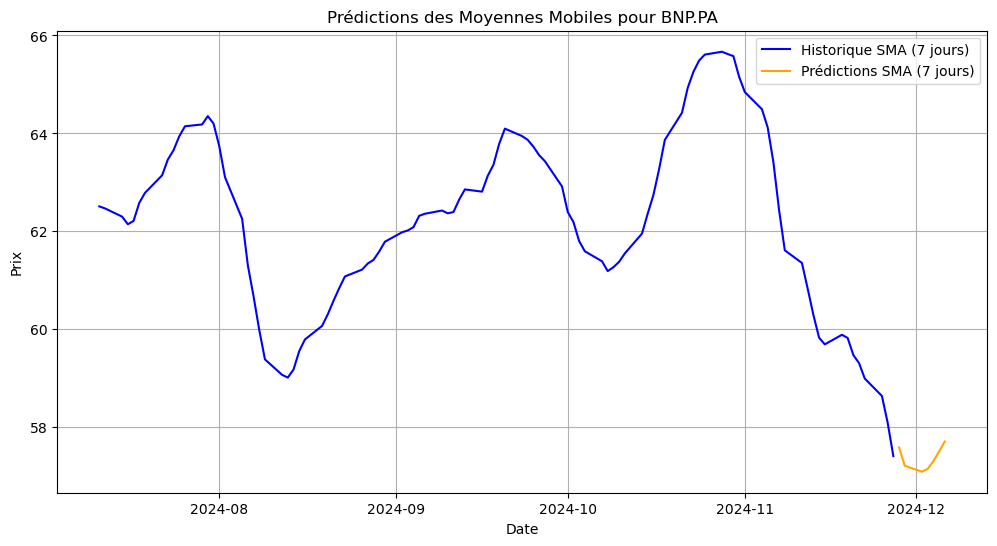

Processing GLE.PA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
60/60 [==============================] - 17s 141ms/step - loss: 0.0168 - val_loss: 0.0014
Epoch 2/50
60/60 [==============================] - 5s 82ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 3/50
60/60 [==============================] - 6s 93ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 4/50
60/60 [==============================] - 5s 87ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 5/50
60/60 [==============================] - 7s 112ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 6/50
60/60 [==============================] - 5s 87ms/step - loss: 0.0029 - val_loss: 7.5353e-04
Epoch 7/50
60/60 [==============================] - 5s 80ms/step - loss: 0.0023 - val_loss: 5.5303e-04
Epoch 8/50
60/60 [==============================] - 4s 75ms/step - loss: 0.0024 - val_loss: 5.0490e-04
Epoch 9/50
60/60 [==============================] - 5s 81ms/step - loss: 0.0020 - val_loss: 4.7985e-04
Epoch 10/50
60/60 [==============================] - 5s 81ms/step - loss: 0.0016 - val_los

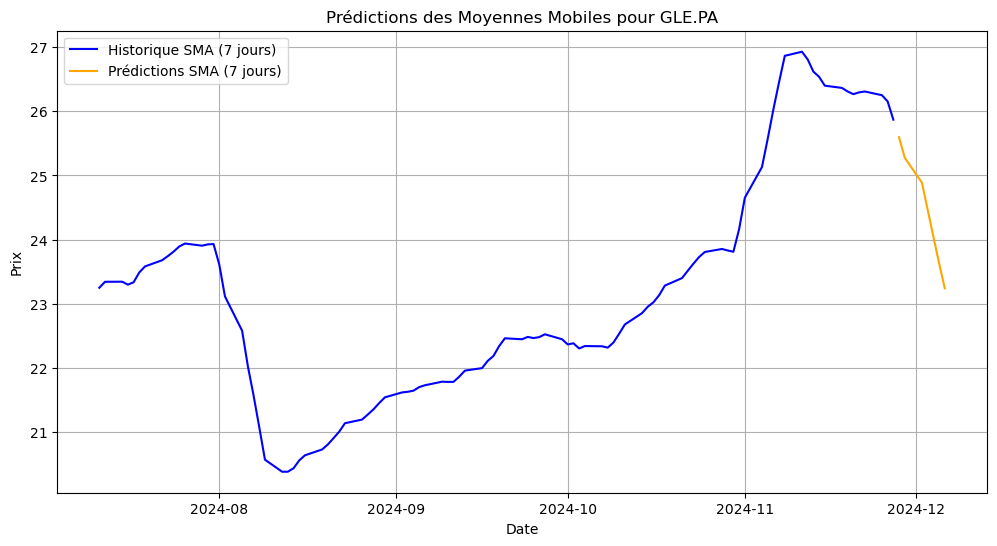

[*********************100%***********************]  1 of 1 completed

Processing ENGI.PA...


Epoch 1/50
60/60 [==============================] - 14s 98ms/step - loss: 0.0215 - val_loss: 0.0022
Epoch 2/50
60/60 [==============================] - 5s 83ms/step - loss: 0.0058 - val_loss: 0.0027
Epoch 3/50
60/60 [==============================] - 5s 84ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 4/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 5/50
60/60 [==============================] - 5s 76ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 6/50
60/60 [==============================] - 5s 80ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 7/50
60/60 [==============================] - 5s 80ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 8/50
60/60 [==============================] - 4s 75ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 9/50
60/60 [==============================] - 5s 82ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/50
60/60 [==============================] - 5s 81ms/step - loss: 0.0022 - val_loss: 6.3700e-04
Epoc

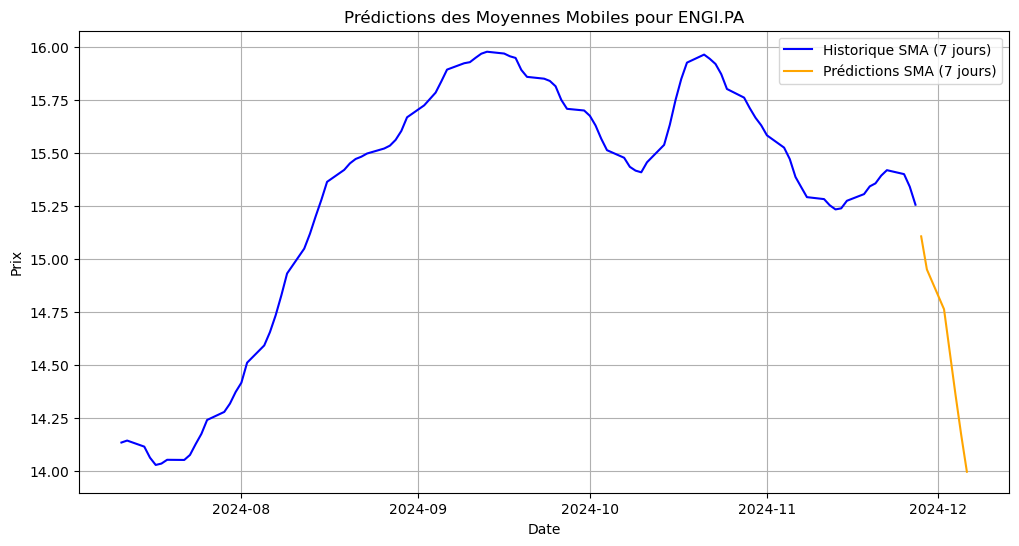

[*********************100%***********************]  1 of 1 completed

Processing VIV.PA...


Epoch 1/50
60/60 [==============================] - 14s 105ms/step - loss: 0.0178 - val_loss: 0.0026
Epoch 2/50
60/60 [==============================] - 5s 80ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 3/50
60/60 [==============================] - 5s 87ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 4/50
60/60 [==============================] - 5s 86ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 6/50
60/60 [==============================] - 5s 89ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 7/50
60/60 [==============================] - 5s 88ms/step - loss: 0.0027 - val_loss: 8.9417e-04
Epoch 8/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/50
60/60 [==============================] - 5s 86ms/step - loss: 0.0020 - val_loss: 6.2402e-04
Epoch 10/50
60/60 [==============================] - 5s 88ms/step - loss: 0.0019 - val_loss: 8.7180

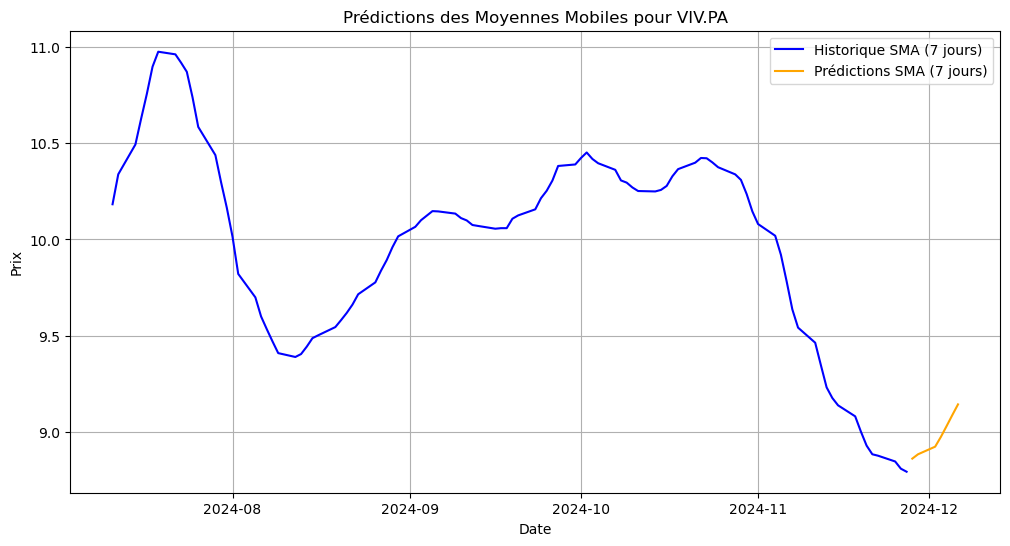

Processing SGO.PA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
60/60 [==============================] - 14s 110ms/step - loss: 0.0113 - val_loss: 0.0028
Epoch 2/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 3/50
60/60 [==============================] - 5s 92ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 4/50
60/60 [==============================] - 5s 89ms/step - loss: 0.0020 - val_loss: 7.7439e-04
Epoch 5/50
60/60 [==============================] - 5s 81ms/step - loss: 0.0018 - val_loss: 6.5571e-04
Epoch 6/50
60/60 [==============================] - 5s 89ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/50
60/60 [==============================] - 5s 88ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/50
60/60 [==============================] - 5s 81ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 9/50
60/60 [==============================] - 5s 85ms/step - loss: 0.0011 - val_loss: 5.1667e-04
Epoch 10/50
60/60 [==============================] - 5s 89ms/step - loss: 8.6726e-04 - val_loss

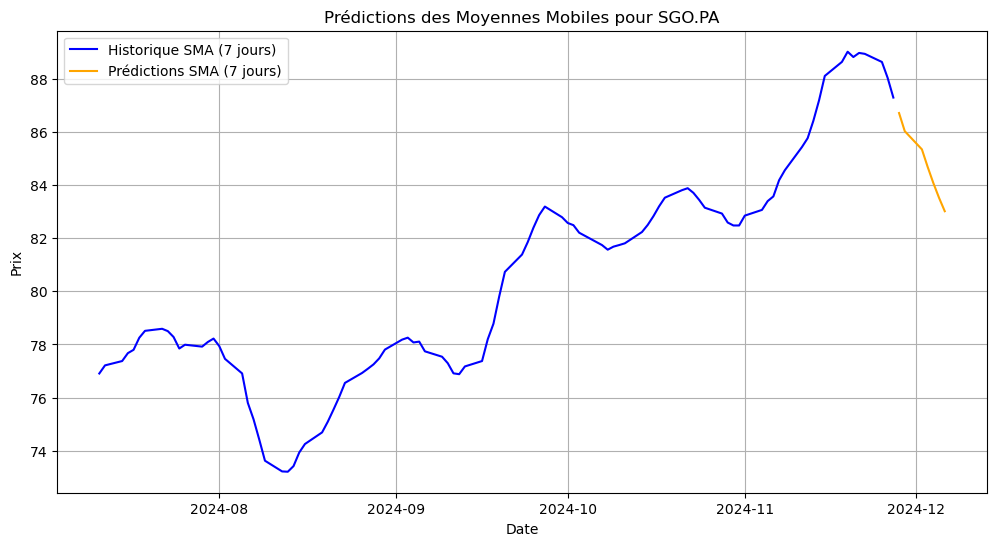

[*********************100%***********************]  1 of 1 completed

Processing CA.PA...


Epoch 1/50
60/60 [==============================] - 14s 119ms/step - loss: 0.0149 - val_loss: 0.0019
Epoch 2/50
60/60 [==============================] - 5s 85ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 3/50
60/60 [==============================] - 5s 89ms/step - loss: 0.0047 - val_loss: 0.0011
Epoch 4/50
60/60 [==============================] - 6s 92ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 5/50
60/60 [==============================] - 5s 86ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 6/50
60/60 [==============================] - 5s 89ms/step - loss: 0.0030 - val_loss: 9.0310e-04
Epoch 7/50
60/60 [==============================] - 6s 92ms/step - loss: 0.0033 - val_loss: 6.8222e-04
Epoch 8/50
60/60 [==============================] - 5s 86ms/step - loss: 0.0024 - val_loss: 8.6453e-04
Epoch 9/50
60/60 [==============================] - 5s 88ms/step - loss: 0.0023 - val_loss: 6.5048e-04
Epoch 10/50
60/60 [==============================] - 6s 93ms/step - loss: 0.0020 - val_loss

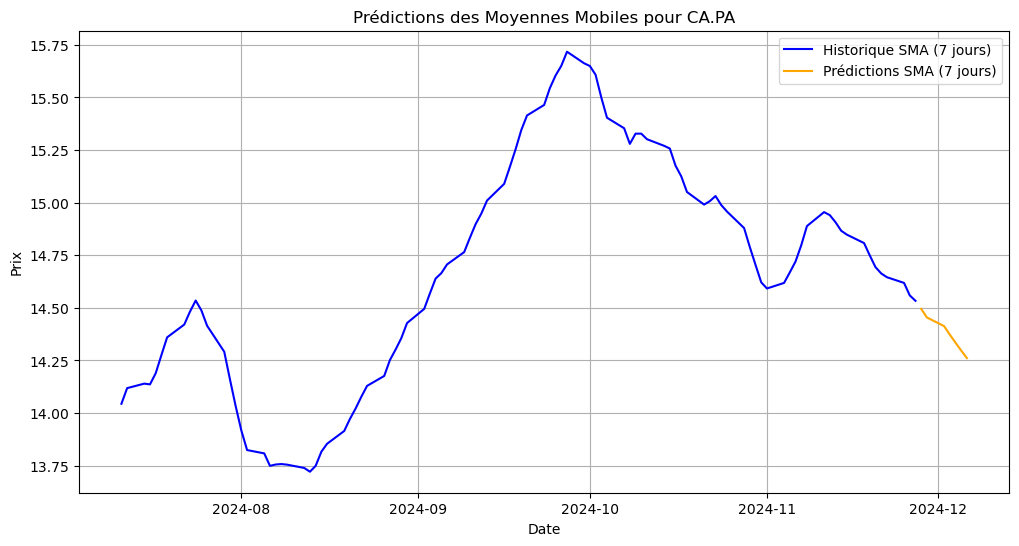

Processing EURUSD=X...


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
61/61 [==============================] - 16s 142ms/step - loss: 0.0263 - val_loss: 8.9534e-04
Epoch 2/50
61/61 [==============================] - 5s 85ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 3/50
61/61 [==============================] - 6s 97ms/step - loss: 0.0055 - val_loss: 0.0010
Epoch 4/50
61/61 [==============================] - 6s 98ms/step - loss: 0.0044 - val_loss: 8.4878e-04
Epoch 5/50
61/61 [==============================] - 6s 94ms/step - loss: 0.0037 - val_loss: 8.0366e-04
Epoch 6/50
61/61 [==============================] - 7s 109ms/step - loss: 0.0040 - val_loss: 6.8413e-04
Epoch 7/50
61/61 [==============================] - 6s 96ms/step - loss: 0.0036 - val_loss: 5.8790e-04
Epoch 8/50
61/61 [==============================] - 6s 93ms/step - loss: 0.0027 - val_loss: 5.7478e-04
Epoch 9/50
61/61 [==============================] - 6s 90ms/step - loss: 0.0025 - val_loss: 4.9402e-04
Epoch 10/50
61/61 [==============================] - 5s 90ms/step - loss: 0.00

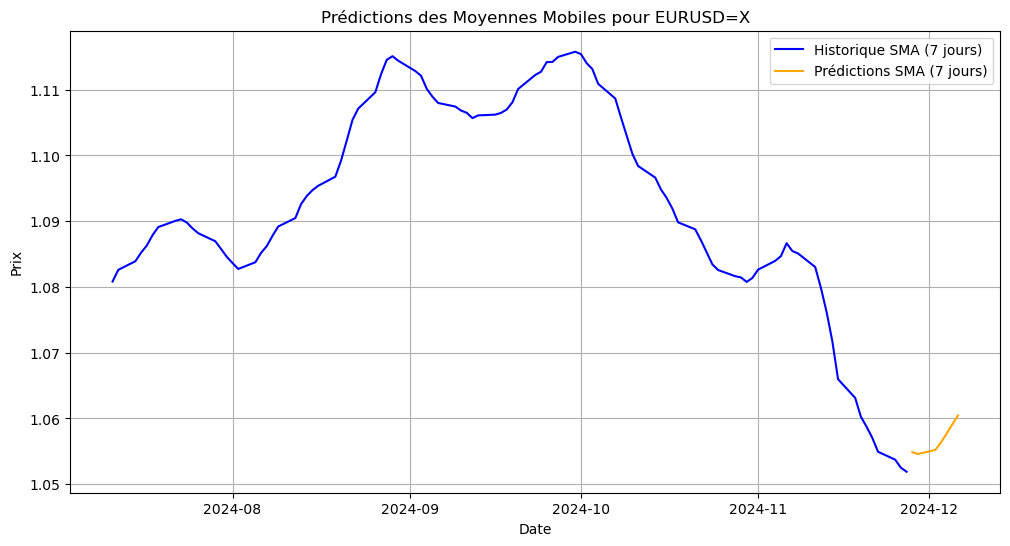

Processing GBPUSD=X...


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
61/61 [==============================] - 14s 107ms/step - loss: 0.0288 - val_loss: 8.1439e-04
Epoch 2/50
61/61 [==============================] - 5s 79ms/step - loss: 0.0062 - val_loss: 9.6181e-04
Epoch 3/50
61/61 [==============================] - 6s 91ms/step - loss: 0.0056 - val_loss: 8.8332e-04
Epoch 4/50
61/61 [==============================] - 5s 89ms/step - loss: 0.0043 - val_loss: 9.0165e-04
Epoch 5/50
61/61 [==============================] - 5s 79ms/step - loss: 0.0043 - val_loss: 7.9332e-04
Epoch 6/50
61/61 [==============================] - 5s 88ms/step - loss: 0.0040 - val_loss: 5.7038e-04
Epoch 7/50
61/61 [==============================] - 5s 88ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 8/50
61/61 [==============================] - 5s 85ms/step - loss: 0.0030 - val_loss: 5.0565e-04
Epoch 9/50
61/61 [==============================] - 5s 90ms/step - loss: 0.0032 - val_loss: 6.7920e-04
Epoch 10/50
61/61 [==============================] - 5s 90ms/step - loss: 0

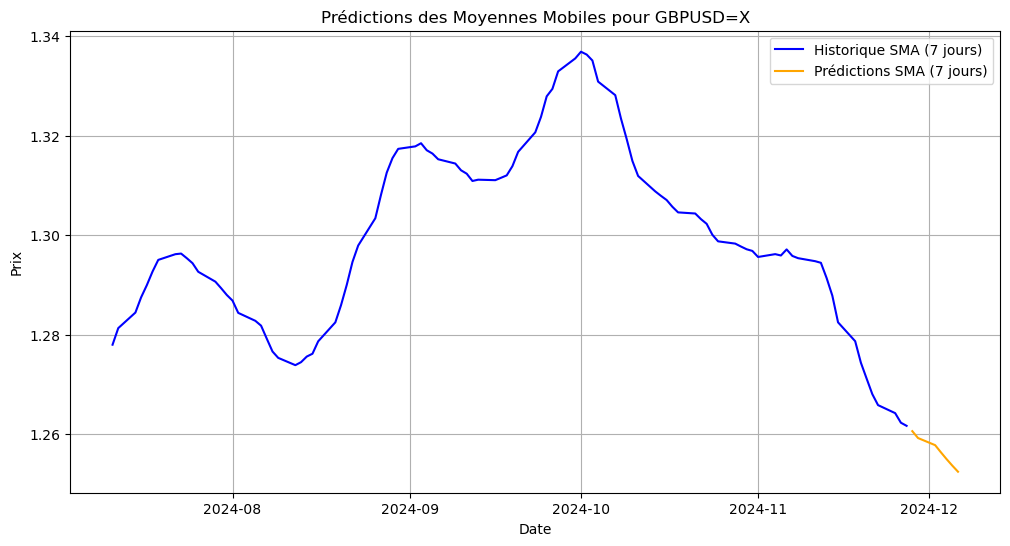

Processing BTC-USD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
87/87 [==============================] - 16s 100ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 2/50
87/87 [==============================] - 7s 84ms/step - loss: 0.0014 - val_loss: 8.7969e-04
Epoch 3/50
87/87 [==============================] - 8s 87ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/50
87/87 [==============================] - 7s 84ms/step - loss: 9.7429e-04 - val_loss: 0.0019
Epoch 5/50
87/87 [==============================] - 8s 90ms/step - loss: 8.5046e-04 - val_loss: 0.0011
Epoch 6/50
87/87 [==============================] - 7s 81ms/step - loss: 7.1362e-04 - val_loss: 7.3761e-04
Epoch 7/50
87/87 [==============================] - 8s 89ms/step - loss: 5.9055e-04 - val_loss: 4.7937e-04
Epoch 8/50
87/87 [==============================] - 7s 82ms/step - loss: 6.3429e-04 - val_loss: 4.3546e-04
Epoch 9/50
87/87 [==============================] - 8s 91ms/step - loss: 6.0690e-04 - val_loss: 0.0018
Epoch 10/50
87/87 [==============================] - 7s 83ms/step -

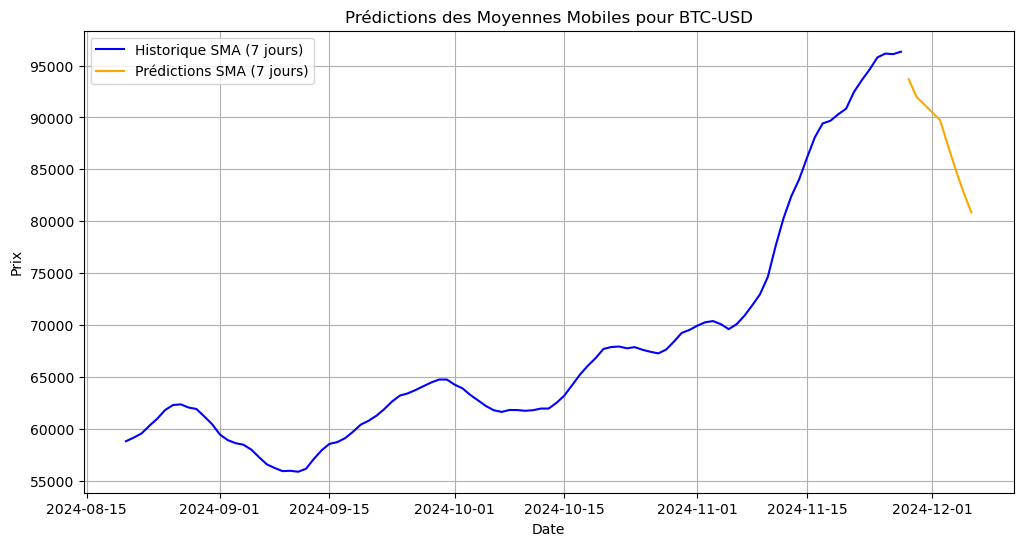

[*********************100%***********************]  1 of 1 completed

Processing ETH-USD...


Epoch 1/50
87/87 [==============================] - 17s 101ms/step - loss: 0.0136 - val_loss: 0.0041
Epoch 2/50
87/87 [==============================] - 8s 87ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 3/50
87/87 [==============================] - 7s 80ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/50
87/87 [==============================] - 8s 89ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/50
87/87 [==============================] - 7s 81ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 6/50
87/87 [==============================] - 8s 87ms/step - loss: 0.0020 - val_loss: 7.2606e-04
Epoch 7/50
87/87 [==============================] - 7s 83ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 8/50
87/87 [==============================] - 8s 88ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/50
87/87 [==============================] - 7s 85ms/step - loss: 0.0013 - val_loss: 9.7698e-04
Epoch 10/50
87/87 [==============================] - 7s 86ms/step - loss: 0.0013 - val_loss: 6.1923

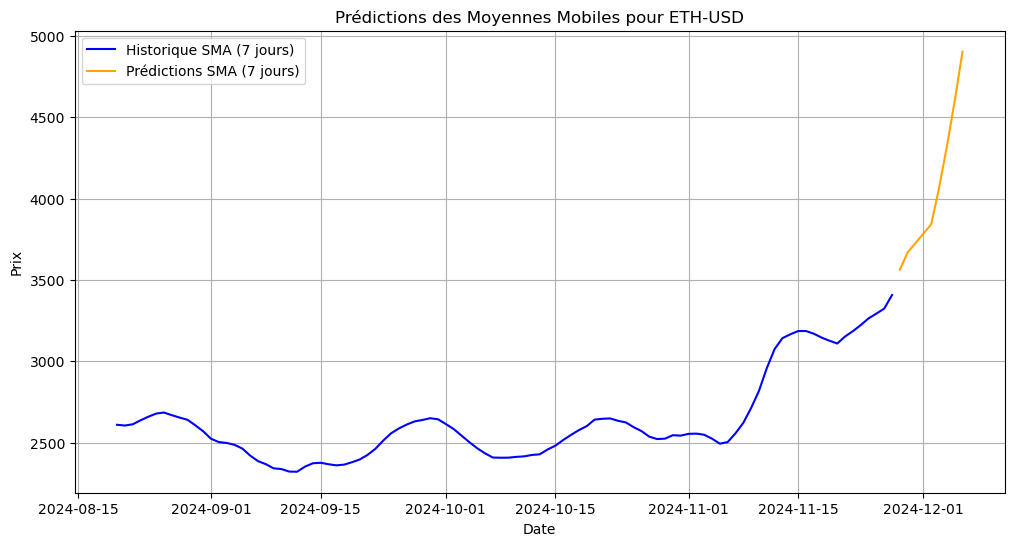

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Liste des tickers
tickers = ['OR.PA', 'AIR.PA', 'SAN.PA', 'BNP.PA', 'GLE.PA', 'ENGI.PA', 'VIV.PA', 'SGO.PA', 'CA.PA',
           'EURUSD=X', 'GBPUSD=X', 'BTC-USD', 'ETH-USD']

# Paramètres
sequence_length = 60
future_days = 7
start_date = "2020-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

# Fonction pour créer des séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parcourir chaque ticker
for ticker in tickers:
    print(f"Processing {ticker}...")
    
    # Récupération des données
    data = yf.download(ticker, start=start_date, end=end_date)
    data["SMA"] = data["Close"].rolling(window=7).mean()
    data = data.dropna()
    
    # Prétraitement
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data["SMA"].values.reshape(-1, 1))
    
    # Création des séquences
    X, y = create_sequences(data_scaled, sequence_length)
    
    # Division des données
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Reshape pour LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Construction du modèle
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Entraînement
    model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test), verbose=1)
    
    # Prédiction
    last_sequence = data_scaled[-sequence_length:]
    predictions = []
    for _ in range(future_days):
        pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
        predictions.append(pred[0][0])
        last_sequence = np.append(last_sequence[1:], pred, axis=0)
    
    # Inversion de la normalisation
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    # Affichage des résultats
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-100:], data["SMA"].iloc[-100:], label="Historique SMA (7 jours)", color="blue")
    future_dates = pd.date_range(start=data.index[-1], periods=future_days + 1, freq="B")[1:]
    plt.plot(future_dates, predictions, label="Prédictions SMA (7 jours)", color="orange")
    plt.title(f"Prédictions des Moyennes Mobiles pour {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid()
    plt.show()
